In [1]:
from rl_ood import *
from pprint import pprint
from tqdm.notebook import tqdm
path = Path.cwd()



In [2]:
NB_EP_EVAL = 2

TODO

explimer le score en % d'optimalite

integrer le in distrib dans le truc

# OOD environments instantiation

In [3]:
ENV_NAME = ['CartPole-v1', 'Pendulum-v1', 'MountainCar-v0', 'MountainCarContinuous-v0'][1]
path_agent = path / 'Agents' / ENV_NAME

if ENV_NAME == 'CartPole-v1':
    default_values = CARTPOLE_VALUES
    ALGO = A2C
    instanciation_function = instanciate_cartpole

elif ENV_NAME == 'Pendulum-v1':
    default_values = PENDULUM_VALUES
    ALGO = PPO
    instanciation_function = instanciate_pendulum

elif ENV_NAME == 'MountainCar-v0':
    default_values = MOUNTAIN_CAR_VALUES
    ALGO = DQN
    instanciation_function = instanciate_mountain_car

elif ENV_NAME == 'MountainCarContinuous-v0':
    default_values = MOUNTAIN_CAR_VALUES
    ALGO = A2C
    instanciation_function = instanciate_mountain_car_continuous

path_agent = path / 'Agents' / ENV_NAME

print("Env name:", ENV_NAME)
print("Defalut values:")
pprint(default_values)

Env name: Pendulum-v1
Defalut values:
{'Gravity': 10.0,
 'Length_pole': 1.0,
 'Mass_pole': 1.0,
 'Max_speed': 8.0,
 'Max_torque': 2.0}


Each ood config differs from the defaut environment by only one attribute.

In [4]:
values = create_ood_values(default_values)
ood_configs = get_ood_configs(default_values, values)
print("Number of attributes:", len(values.keys()))
print("Number of ood values per attribute:", len(values['Gravity']))


print("Number of OOD configs:", len(ood_configs))

Number of attributes: 5
Number of ood values per attribute: 21
Number of OOD configs: 105


# Evaluate OOD impact

### Original environment

We train an agent on the original environment, and we evaluate its performances

In [5]:
env = instanciation_function(default_values)

try:
    agent = ALGO.load(path_agent, env=env)
except:
    if ENV_NAME == 'CartPole-v1':
        agent = A2C('MlpPolicy', env)
        agent.learn(10000)

    elif ENV_NAME == 'Pendulum-v1':

        agent = agent = PPO(
            "MlpPolicy",
            env,
            gamma=0.98,
            use_sde=True,
            sde_sample_freq=4,
            learning_rate=1e-3,
            verbose=1,
        )
        agent.learn(1000000, progress_bar=True)

    elif ENV_NAME == 'MountainCar-v0':
        agent = DQN('MlpPolicy', env, learning_rate=0.001, buffer_size=10000, learning_starts=50000, batch_size=128, tau=1.0, gamma=0.99, train_freq=4)
        agent.learn(1000000, progress_bar=True)

    elif ENV_NAME == 'MountainCarContinuous-v0':
        agent = A2C('MlpPolicy', env)
        agent.learn(1000000, progress_bar=True)

    agent.save(path_agent)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+03     |
|    ep_rew_mean     | -5.83e+03 |
| time/              |           |
|    fps             | 682       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -5.69e+03  |
| time/                   |            |
|    fps                  | 647        |
|    iterations           | 2          |
|    time_elapsed         | 6          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00552739 |
|    clip_fraction        | 0.0325     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.71      |
|    explained_variance   | 0.00586    |
|    learning_rate        | 0.001      |
|    loss                 | 1.72e+03   |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.00706   |
|    std                  | 0.968      |
|    value_loss           | 5.6e+03    |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -5.88e+03   |
| time/                   |             |
|    fps                  | 628         |
|    iterations           | 3           |
|    time_elapsed         | 9           |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.008557791 |
|    clip_fraction        | 0.0893      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.8        |
|    explained_variance   | 0.00761     |
|    learning_rate        | 0.001       |
|    loss                 | 1.46e+03    |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0123     |
|    std                  | 0.942       |
|    value_loss           | 3.95e+03    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -5.94e+03   |
| time/                   |             |
|    fps                  | 644         |
|    iterations           | 4           |
|    time_elapsed         | 12          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.009430168 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.57       |
|    explained_variance   | 0.000412    |
|    learning_rate        | 0.001       |
|    loss                 | 1.7e+03     |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0105     |
|    std                  | 0.937       |
|    value_loss           | 4.75e+03    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -5.91e+03   |
| time/                   |             |
|    fps                  | 657         |
|    iterations           | 5           |
|    time_elapsed         | 15          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.007166976 |
|    clip_fraction        | 0.0496      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.63       |
|    explained_variance   | 0.00134     |
|    learning_rate        | 0.001       |
|    loss                 | 1.04e+03    |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00688    |
|    std                  | 0.919       |
|    value_loss           | 3.39e+03    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -5.85e+03    |
| time/                   |              |
|    fps                  | 622          |
|    iterations           | 6            |
|    time_elapsed         | 19           |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 0.0049857954 |
|    clip_fraction        | 0.0342       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.6         |
|    explained_variance   | 0.000632     |
|    learning_rate        | 0.001        |
|    loss                 | 967          |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00616     |
|    std                  | 0.896        |
|    value_loss           | 2.59e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -5.92e+03   |
| time/                   |             |
|    fps                  | 630         |
|    iterations           | 7           |
|    time_elapsed         | 22          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.007749989 |
|    clip_fraction        | 0.0638      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | 0.000396    |
|    learning_rate        | 0.001       |
|    loss                 | 603         |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00715    |
|    std                  | 0.866       |
|    value_loss           | 1.78e+03    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -5.86e+03   |
| time/                   |             |
|    fps                  | 619         |
|    iterations           | 8           |
|    time_elapsed         | 26          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.008093239 |
|    clip_fraction        | 0.0758      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.51       |
|    explained_variance   | 0.000221    |
|    learning_rate        | 0.001       |
|    loss                 | 570         |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0066     |
|    std                  | 0.855       |
|    value_loss           | 1.94e+03    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -5.82e+03   |
| time/                   |             |
|    fps                  | 637         |
|    iterations           | 9           |
|    time_elapsed         | 28          |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.017616333 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.69       |
|    explained_variance   | 0.00014     |
|    learning_rate        | 0.001       |
|    loss                 | 404         |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0182     |
|    std                  | 0.847       |
|    value_loss           | 1.02e+03    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -5.8e+03    |
| time/                   |             |
|    fps                  | 622         |
|    iterations           | 10          |
|    time_elapsed         | 32          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.013471168 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.66       |
|    explained_variance   | 8.75e-05    |
|    learning_rate        | 0.001       |
|    loss                 | 195         |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0136     |
|    std                  | 0.875       |
|    value_loss           | 691         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -5.74e+03   |
| time/                   |             |
|    fps                  | 613         |
|    iterations           | 11          |
|    time_elapsed         | 36          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.041385286 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.59       |
|    explained_variance   | 0.000112    |
|    learning_rate        | 0.001       |
|    loss                 | 182         |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00682    |
|    std                  | 0.811       |
|    value_loss           | 561         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -5.68e+03   |
| time/                   |             |
|    fps                  | 611         |
|    iterations           | 12          |
|    time_elapsed         | 40          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.008279337 |
|    clip_fraction        | 0.0587      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.52       |
|    explained_variance   | 0.108       |
|    learning_rate        | 0.001       |
|    loss                 | 187         |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00763    |
|    std                  | 0.786       |
|    value_loss           | 560         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -5.65e+03   |
| time/                   |             |
|    fps                  | 592         |
|    iterations           | 13          |
|    time_elapsed         | 44          |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.024983054 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.56       |
|    explained_variance   | 0.411       |
|    learning_rate        | 0.001       |
|    loss                 | 101         |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0238     |
|    std                  | 0.788       |
|    value_loss           | 340         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -5.57e+03   |
| time/                   |             |
|    fps                  | 587         |
|    iterations           | 14          |
|    time_elapsed         | 48          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.008771528 |
|    clip_fraction        | 0.0726      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.54       |
|    explained_variance   | 0.576       |
|    learning_rate        | 0.001       |
|    loss                 | 83.7        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0155     |
|    std                  | 0.748       |
|    value_loss           | 250         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -5.53e+03   |
| time/                   |             |
|    fps                  | 583         |
|    iterations           | 15          |
|    time_elapsed         | 52          |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.013636263 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.51       |
|    explained_variance   | 0.677       |
|    learning_rate        | 0.001       |
|    loss                 | 83.5        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0169     |
|    std                  | 0.709       |
|    value_loss           | 251         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -5.45e+03   |
| time/                   |             |
|    fps                  | 589         |
|    iterations           | 16          |
|    time_elapsed         | 55          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.013355795 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.52       |
|    explained_variance   | 0.703       |
|    learning_rate        | 0.001       |
|    loss                 | 121         |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.0259     |
|    std                  | 0.694       |
|    value_loss           | 238         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -5.37e+03   |
| time/                   |             |
|    fps                  | 595         |
|    iterations           | 17          |
|    time_elapsed         | 58          |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.015447361 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.51       |
|    explained_variance   | 0.755       |
|    learning_rate        | 0.001       |
|    loss                 | 126         |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0187     |
|    std                  | 0.661       |
|    value_loss           | 178         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -5.27e+03  |
| time/                   |            |
|    fps                  | 591        |
|    iterations           | 18         |
|    time_elapsed         | 62         |
|    total_timesteps      | 36864      |
| train/                  |            |
|    approx_kl            | 0.01971682 |
|    clip_fraction        | 0.175      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.47      |
|    explained_variance   | 0.749      |
|    learning_rate        | 0.001      |
|    loss                 | 112        |
|    n_updates            | 170        |
|    policy_gradient_loss | -0.0294    |
|    std                  | 0.627      |
|    value_loss           | 193        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -5.15e+03  |
| time/                   |            |
|    fps                  | 595        |
|    iterations           | 19         |
|    time_elapsed         | 65         |
|    total_timesteps      | 38912      |
| train/                  |            |
|    approx_kl            | 0.01262188 |
|    clip_fraction        | 0.121      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.41      |
|    explained_variance   | 0.755      |
|    learning_rate        | 0.001      |
|    loss                 | 182        |
|    n_updates            | 180        |
|    policy_gradient_loss | -0.0191    |
|    std                  | 0.595      |
|    value_loss           | 279        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -5.01e+03    |
| time/                   |              |
|    fps                  | 603          |
|    iterations           | 20           |
|    time_elapsed         | 67           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0108319875 |
|    clip_fraction        | 0.126        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.32        |
|    explained_variance   | 0.753        |
|    learning_rate        | 0.001        |
|    loss                 | 197          |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.0178      |
|    std                  | 0.571        |
|    value_loss           | 363          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -4.86e+03   |
| time/                   |             |
|    fps                  | 608         |
|    iterations           | 21          |
|    time_elapsed         | 70          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.009534415 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.3        |
|    explained_variance   | 0.749       |
|    learning_rate        | 0.001       |
|    loss                 | 189         |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0221     |
|    std                  | 0.554       |
|    value_loss           | 420         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -4.73e+03   |
| time/                   |             |
|    fps                  | 610         |
|    iterations           | 22          |
|    time_elapsed         | 73          |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.016189687 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.31       |
|    explained_variance   | 0.804       |
|    learning_rate        | 0.001       |
|    loss                 | 198         |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0254     |
|    std                  | 0.524       |
|    value_loss           | 330         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -4.6e+03    |
| time/                   |             |
|    fps                  | 614         |
|    iterations           | 23          |
|    time_elapsed         | 76          |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.018915731 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.17       |
|    explained_variance   | 0.795       |
|    learning_rate        | 0.001       |
|    loss                 | 129         |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0266     |
|    std                  | 0.498       |
|    value_loss           | 333         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -4.45e+03   |
| time/                   |             |
|    fps                  | 612         |
|    iterations           | 24          |
|    time_elapsed         | 80          |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.015417408 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.08       |
|    explained_variance   | 0.823       |
|    learning_rate        | 0.001       |
|    loss                 | 113         |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.0233     |
|    std                  | 0.48        |
|    value_loss           | 249         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -4.32e+03   |
| time/                   |             |
|    fps                  | 616         |
|    iterations           | 25          |
|    time_elapsed         | 82          |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.014374636 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | 0.815       |
|    learning_rate        | 0.001       |
|    loss                 | 91.5        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00607    |
|    std                  | 0.451       |
|    value_loss           | 197         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -4.19e+03   |
| time/                   |             |
|    fps                  | 616         |
|    iterations           | 26          |
|    time_elapsed         | 86          |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.022999462 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.96       |
|    explained_variance   | 0.84        |
|    learning_rate        | 0.001       |
|    loss                 | 172         |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.014      |
|    std                  | 0.44        |
|    value_loss           | 252         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -4.07e+03   |
| time/                   |             |
|    fps                  | 620         |
|    iterations           | 27          |
|    time_elapsed         | 89          |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.016175292 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.89       |
|    explained_variance   | 0.827       |
|    learning_rate        | 0.001       |
|    loss                 | 128         |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0076     |
|    std                  | 0.427       |
|    value_loss           | 281         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -3.94e+03   |
| time/                   |             |
|    fps                  | 621         |
|    iterations           | 28          |
|    time_elapsed         | 92          |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.016640833 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.76       |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.001       |
|    loss                 | 21.3        |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.000556   |
|    std                  | 0.403       |
|    value_loss           | 86.4        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -3.82e+03   |
| time/                   |             |
|    fps                  | 626         |
|    iterations           | 29          |
|    time_elapsed         | 94          |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.020162392 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.78       |
|    explained_variance   | 0.837       |
|    learning_rate        | 0.001       |
|    loss                 | 25.4        |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00137    |
|    std                  | 0.395       |
|    value_loss           | 71.9        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -3.71e+03  |
| time/                   |            |
|    fps                  | 626        |
|    iterations           | 30         |
|    time_elapsed         | 98         |
|    total_timesteps      | 61440      |
| train/                  |            |
|    approx_kl            | 0.03328358 |
|    clip_fraction        | 0.226      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.79      |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.001      |
|    loss                 | 159        |
|    n_updates            | 290        |
|    policy_gradient_loss | -0.0165    |
|    std                  | 0.38       |
|    value_loss           | 194        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -3.61e+03  |
| time/                   |            |
|    fps                  | 630        |
|    iterations           | 31         |
|    time_elapsed         | 100        |
|    total_timesteps      | 63488      |
| train/                  |            |
|    approx_kl            | 0.14214352 |
|    clip_fraction        | 0.406      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.74      |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.001      |
|    loss                 | 0.481      |
|    n_updates            | 300        |
|    policy_gradient_loss | 0.015      |
|    std                  | 0.391      |
|    value_loss           | 9.25       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -3.52e+03   |
| time/                   |             |
|    fps                  | 630         |
|    iterations           | 32          |
|    time_elapsed         | 103         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.009094102 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.81       |
|    explained_variance   | 0.879       |
|    learning_rate        | 0.001       |
|    loss                 | 50.3        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0157     |
|    std                  | 0.388       |
|    value_loss           | 107         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -3.43e+03    |
| time/                   |              |
|    fps                  | 631          |
|    iterations           | 33           |
|    time_elapsed         | 107          |
|    total_timesteps      | 67584        |
| train/                  |              |
|    approx_kl            | 0.0034532887 |
|    clip_fraction        | 0.0304       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.79        |
|    explained_variance   | 0.921        |
|    learning_rate        | 0.001        |
|    loss                 | 108          |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0103      |
|    std                  | 0.383        |
|    value_loss           | 127          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -3.35e+03   |
| time/                   |             |
|    fps                  | 633         |
|    iterations           | 34          |
|    time_elapsed         | 109         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.009509122 |
|    clip_fraction        | 0.0877      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.76       |
|    explained_variance   | 0.887       |
|    learning_rate        | 0.001       |
|    loss                 | 112         |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.0159     |
|    std                  | 0.377       |
|    value_loss           | 141         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -3.27e+03  |
| time/                   |            |
|    fps                  | 634        |
|    iterations           | 35         |
|    time_elapsed         | 113        |
|    total_timesteps      | 71680      |
| train/                  |            |
|    approx_kl            | 0.01733766 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.72      |
|    explained_variance   | 0.859      |
|    learning_rate        | 0.001      |
|    loss                 | 8.84       |
|    n_updates            | 340        |
|    policy_gradient_loss | -0.0122    |
|    std                  | 0.367      |
|    value_loss           | 45.1       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -3.2e+03    |
| time/                   |             |
|    fps                  | 627         |
|    iterations           | 36          |
|    time_elapsed         | 117         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.018982347 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.944       |
|    learning_rate        | 0.001       |
|    loss                 | 30          |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.0255     |
|    std                  | 0.363       |
|    value_loss           | 76.2        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -3.13e+03   |
| time/                   |             |
|    fps                  | 620         |
|    iterations           | 37          |
|    time_elapsed         | 122         |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.018606987 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.883       |
|    learning_rate        | 0.001       |
|    loss                 | 9.44        |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.015      |
|    std                  | 0.354       |
|    value_loss           | 101         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -3.05e+03   |
| time/                   |             |
|    fps                  | 614         |
|    iterations           | 38          |
|    time_elapsed         | 126         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.051976692 |
|    clip_fraction        | 0.309       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.811       |
|    learning_rate        | 0.001       |
|    loss                 | 2.19        |
|    n_updates            | 370         |
|    policy_gradient_loss | 0.000822    |
|    std                  | 0.331       |
|    value_loss           | 35.4        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | -2.98e+03 |
| time/                   |           |
|    fps                  | 613       |
|    iterations           | 39        |
|    time_elapsed         | 130       |
|    total_timesteps      | 79872     |
| train/                  |           |
|    approx_kl            | 0.3021788 |
|    clip_fraction        | 0.482     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.66     |
|    explained_variance   | 0.902     |
|    learning_rate        | 0.001     |
|    loss                 | 0.581     |
|    n_updates            | 380       |
|    policy_gradient_loss | 0.00749   |
|    std                  | 0.313     |
|    value_loss           | 34.7      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -2.92e+03   |
| time/                   |             |
|    fps                  | 614         |
|    iterations           | 40          |
|    time_elapsed         | 133         |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.015781429 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.001       |
|    loss                 | 42          |
|    n_updates            | 390         |
|    policy_gradient_loss | 0.000391    |
|    std                  | 0.317       |
|    value_loss           | 30.4        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -2.86e+03  |
| time/                   |            |
|    fps                  | 609        |
|    iterations           | 41         |
|    time_elapsed         | 137        |
|    total_timesteps      | 83968      |
| train/                  |            |
|    approx_kl            | 0.05270271 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.62      |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.001      |
|    loss                 | 39.4       |
|    n_updates            | 400        |
|    policy_gradient_loss | -0.0121    |
|    std                  | 0.314      |
|    value_loss           | 56.6       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -2.77e+03   |
| time/                   |             |
|    fps                  | 605         |
|    iterations           | 42          |
|    time_elapsed         | 142         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.043633007 |
|    clip_fraction        | 0.459       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.947       |
|    learning_rate        | 0.001       |
|    loss                 | 16          |
|    n_updates            | 410         |
|    policy_gradient_loss | 0.00309     |
|    std                  | 0.315       |
|    value_loss           | 18.5        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -2.74e+03   |
| time/                   |             |
|    fps                  | 602         |
|    iterations           | 43          |
|    time_elapsed         | 146         |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.014947288 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0.884       |
|    learning_rate        | 0.001       |
|    loss                 | 15          |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.0123     |
|    std                  | 0.311       |
|    value_loss           | 82          |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -2.7e+03    |
| time/                   |             |
|    fps                  | 597         |
|    iterations           | 44          |
|    time_elapsed         | 150         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.019857332 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.894       |
|    learning_rate        | 0.001       |
|    loss                 | 140         |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.0259     |
|    std                  | 0.306       |
|    value_loss           | 203         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -2.64e+03   |
| time/                   |             |
|    fps                  | 592         |
|    iterations           | 45          |
|    time_elapsed         | 155         |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.005093363 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.9         |
|    learning_rate        | 0.001       |
|    loss                 | 71.3        |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.018      |
|    std                  | 0.305       |
|    value_loss           | 259         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -2.59e+03   |
| time/                   |             |
|    fps                  | 593         |
|    iterations           | 46          |
|    time_elapsed         | 158         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.019309713 |
|    clip_fraction        | 0.244       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.848       |
|    learning_rate        | 0.001       |
|    loss                 | 1.53        |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.0116     |
|    std                  | 0.303       |
|    value_loss           | 48.9        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -2.55e+03  |
| time/                   |            |
|    fps                  | 593        |
|    iterations           | 47         |
|    time_elapsed         | 162        |
|    total_timesteps      | 96256      |
| train/                  |            |
|    approx_kl            | 0.01960814 |
|    clip_fraction        | 0.312      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.61      |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.001      |
|    loss                 | 16.4       |
|    n_updates            | 460        |
|    policy_gradient_loss | 0.000729   |
|    std                  | 0.305      |
|    value_loss           | 38.3       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -2.51e+03   |
| time/                   |             |
|    fps                  | 593         |
|    iterations           | 48          |
|    time_elapsed         | 165         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.018694421 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.872       |
|    learning_rate        | 0.001       |
|    loss                 | 26.6        |
|    n_updates            | 470         |
|    policy_gradient_loss | -0.0275     |
|    std                  | 0.305       |
|    value_loss           | 78          |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -2.47e+03  |
| time/                   |            |
|    fps                  | 592        |
|    iterations           | 49         |
|    time_elapsed         | 169        |
|    total_timesteps      | 100352     |
| train/                  |            |
|    approx_kl            | 0.10927251 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.63      |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.001      |
|    loss                 | 52.3       |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.011     |
|    std                  | 0.298      |
|    value_loss           | 48         |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -2.36e+03   |
| time/                   |             |
|    fps                  | 588         |
|    iterations           | 50          |
|    time_elapsed         | 174         |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.018404579 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | 0.945       |
|    learning_rate        | 0.001       |
|    loss                 | 9.42        |
|    n_updates            | 490         |
|    policy_gradient_loss | -0.0225     |
|    std                  | 0.296       |
|    value_loss           | 51          |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -2.25e+03  |
| time/                   |            |
|    fps                  | 581        |
|    iterations           | 51         |
|    time_elapsed         | 179        |
|    total_timesteps      | 104448     |
| train/                  |            |
|    approx_kl            | 0.02523862 |
|    clip_fraction        | 0.414      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.56      |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.001      |
|    loss                 | 20.6       |
|    n_updates            | 500        |
|    policy_gradient_loss | 0.00194    |
|    std                  | 0.29       |
|    value_loss           | 27.5       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -2.17e+03   |
| time/                   |             |
|    fps                  | 578         |
|    iterations           | 52          |
|    time_elapsed         | 184         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.055306576 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.001       |
|    loss                 | 7.19        |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.0122     |
|    std                  | 0.283       |
|    value_loss           | 20.5        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -2.16e+03   |
| time/                   |             |
|    fps                  | 579         |
|    iterations           | 53          |
|    time_elapsed         | 187         |
|    total_timesteps      | 108544      |
| train/                  |             |
|    approx_kl            | 0.022158016 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.63        |
|    learning_rate        | 0.001       |
|    loss                 | 23          |
|    n_updates            | 520         |
|    policy_gradient_loss | -0.0237     |
|    std                  | 0.28        |
|    value_loss           | 248         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -2.07e+03  |
| time/                   |            |
|    fps                  | 581        |
|    iterations           | 54         |
|    time_elapsed         | 190        |
|    total_timesteps      | 110592     |
| train/                  |            |
|    approx_kl            | 0.02364976 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.75      |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.001      |
|    loss                 | 85.1       |
|    n_updates            | 530        |
|    policy_gradient_loss | -0.0276    |
|    std                  | 0.278      |
|    value_loss           | 264        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -2.03e+03   |
| time/                   |             |
|    fps                  | 581         |
|    iterations           | 55          |
|    time_elapsed         | 193         |
|    total_timesteps      | 112640      |
| train/                  |             |
|    approx_kl            | 0.016503587 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.001       |
|    loss                 | 92.4        |
|    n_updates            | 540         |
|    policy_gradient_loss | -0.021      |
|    std                  | 0.278       |
|    value_loss           | 256         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.95e+03   |
| time/                   |             |
|    fps                  | 583         |
|    iterations           | 56          |
|    time_elapsed         | 196         |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.015312412 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.001       |
|    loss                 | 102         |
|    n_updates            | 550         |
|    policy_gradient_loss | -0.0279     |
|    std                  | 0.274       |
|    value_loss           | 392         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.85e+03   |
| time/                   |             |
|    fps                  | 584         |
|    iterations           | 57          |
|    time_elapsed         | 199         |
|    total_timesteps      | 116736      |
| train/                  |             |
|    approx_kl            | 0.010352813 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.58       |
|    explained_variance   | 0.936       |
|    learning_rate        | 0.001       |
|    loss                 | 171         |
|    n_updates            | 560         |
|    policy_gradient_loss | -0.0227     |
|    std                  | 0.27        |
|    value_loss           | 397         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.74e+03   |
| time/                   |             |
|    fps                  | 582         |
|    iterations           | 58          |
|    time_elapsed         | 203         |
|    total_timesteps      | 118784      |
| train/                  |             |
|    approx_kl            | 0.016219102 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.44       |
|    explained_variance   | 0.783       |
|    learning_rate        | 0.001       |
|    loss                 | 78.1        |
|    n_updates            | 570         |
|    policy_gradient_loss | -0.0156     |
|    std                  | 0.269       |
|    value_loss           | 219         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.63e+03   |
| time/                   |             |
|    fps                  | 584         |
|    iterations           | 59          |
|    time_elapsed         | 206         |
|    total_timesteps      | 120832      |
| train/                  |             |
|    approx_kl            | 0.028587969 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.872       |
|    learning_rate        | 0.001       |
|    loss                 | 13.8        |
|    n_updates            | 580         |
|    policy_gradient_loss | -0.00888    |
|    std                  | 0.266       |
|    value_loss           | 49.6        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -1.54e+03  |
| time/                   |            |
|    fps                  | 584        |
|    iterations           | 60         |
|    time_elapsed         | 210        |
|    total_timesteps      | 122880     |
| train/                  |            |
|    approx_kl            | 0.03461674 |
|    clip_fraction        | 0.464      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.49      |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.001      |
|    loss                 | 0.0486     |
|    n_updates            | 590        |
|    policy_gradient_loss | 0.0178     |
|    std                  | 0.248      |
|    value_loss           | 1.75       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.44e+03   |
| time/                   |             |
|    fps                  | 585         |
|    iterations           | 61          |
|    time_elapsed         | 213         |
|    total_timesteps      | 124928      |
| train/                  |             |
|    approx_kl            | 0.009198463 |
|    clip_fraction        | 0.089       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.47       |
|    explained_variance   | 0.845       |
|    learning_rate        | 0.001       |
|    loss                 | 33.5        |
|    n_updates            | 600         |
|    policy_gradient_loss | -0.0164     |
|    std                  | 0.246       |
|    value_loss           | 95.5        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.34e+03   |
| time/                   |             |
|    fps                  | 585         |
|    iterations           | 62          |
|    time_elapsed         | 216         |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.018860307 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.44       |
|    explained_variance   | 0.835       |
|    learning_rate        | 0.001       |
|    loss                 | 1.16        |
|    n_updates            | 610         |
|    policy_gradient_loss | 0.0012      |
|    std                  | 0.242       |
|    value_loss           | 35.5        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.22e+03   |
| time/                   |             |
|    fps                  | 586         |
|    iterations           | 63          |
|    time_elapsed         | 220         |
|    total_timesteps      | 129024      |
| train/                  |             |
|    approx_kl            | 0.035942677 |
|    clip_fraction        | 0.416       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.001       |
|    loss                 | 0.0855      |
|    n_updates            | 620         |
|    policy_gradient_loss | -0.0129     |
|    std                  | 0.228       |
|    value_loss           | 1.53        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.13e+03   |
| time/                   |             |
|    fps                  | 588         |
|    iterations           | 64          |
|    time_elapsed         | 222         |
|    total_timesteps      | 131072      |
| train/                  |             |
|    approx_kl            | 0.005707997 |
|    clip_fraction        | 0.044       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.896       |
|    learning_rate        | 0.001       |
|    loss                 | 103         |
|    n_updates            | 630         |
|    policy_gradient_loss | -0.00693    |
|    std                  | 0.229       |
|    value_loss           | 117         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.06e+03   |
| time/                   |             |
|    fps                  | 588         |
|    iterations           | 65          |
|    time_elapsed         | 226         |
|    total_timesteps      | 133120      |
| train/                  |             |
|    approx_kl            | 0.018206669 |
|    clip_fraction        | 0.291       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.39       |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.001       |
|    loss                 | 0.0234      |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.0053     |
|    std                  | 0.226       |
|    value_loss           | 7.7         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -978         |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 66           |
|    time_elapsed         | 229          |
|    total_timesteps      | 135168       |
| train/                  |              |
|    approx_kl            | 0.0035730256 |
|    clip_fraction        | 0.0915       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | 0.886        |
|    learning_rate        | 0.001        |
|    loss                 | 13.8         |
|    n_updates            | 650          |
|    policy_gradient_loss | 0.000581     |
|    std                  | 0.224        |
|    value_loss           | 102          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -919        |
| time/                   |             |
|    fps                  | 588         |
|    iterations           | 67          |
|    time_elapsed         | 233         |
|    total_timesteps      | 137216      |
| train/                  |             |
|    approx_kl            | 0.037537083 |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.001       |
|    loss                 | 0.616       |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.00808    |
|    std                  | 0.217       |
|    value_loss           | 1.41        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -945        |
| time/                   |             |
|    fps                  | 588         |
|    iterations           | 68          |
|    time_elapsed         | 236         |
|    total_timesteps      | 139264      |
| train/                  |             |
|    approx_kl            | 0.009578015 |
|    clip_fraction        | 0.292       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.4        |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.001       |
|    loss                 | 37.6        |
|    n_updates            | 670         |
|    policy_gradient_loss | 0.000729    |
|    std                  | 0.218       |
|    value_loss           | 111         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -904        |
| time/                   |             |
|    fps                  | 582         |
|    iterations           | 69          |
|    time_elapsed         | 242         |
|    total_timesteps      | 141312      |
| train/                  |             |
|    approx_kl            | 0.018556181 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.44       |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.001       |
|    loss                 | 12.8        |
|    n_updates            | 680         |
|    policy_gradient_loss | -0.0197     |
|    std                  | 0.218       |
|    value_loss           | 93.4        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -851         |
| time/                   |              |
|    fps                  | 576          |
|    iterations           | 70           |
|    time_elapsed         | 248          |
|    total_timesteps      | 143360       |
| train/                  |              |
|    approx_kl            | 0.0088092275 |
|    clip_fraction        | 0.0758       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.33        |
|    explained_variance   | 0.791        |
|    learning_rate        | 0.001        |
|    loss                 | 12.5         |
|    n_updates            | 690          |
|    policy_gradient_loss | -0.012       |
|    std                  | 0.215        |
|    value_loss           | 133          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -822         |
| time/                   |              |
|    fps                  | 573          |
|    iterations           | 71           |
|    time_elapsed         | 253          |
|    total_timesteps      | 145408       |
| train/                  |              |
|    approx_kl            | 0.0057546976 |
|    clip_fraction        | 0.048        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.31        |
|    explained_variance   | 0.87         |
|    learning_rate        | 0.001        |
|    loss                 | 13.6         |
|    n_updates            | 700          |
|    policy_gradient_loss | -0.0124      |
|    std                  | 0.213        |
|    value_loss           | 90.1         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -796        |
| time/                   |             |
|    fps                  | 575         |
|    iterations           | 72          |
|    time_elapsed         | 256         |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.033603616 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.001       |
|    loss                 | 3.59        |
|    n_updates            | 710         |
|    policy_gradient_loss | -0.00955    |
|    std                  | 0.213       |
|    value_loss           | 28.5        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -787        |
| time/                   |             |
|    fps                  | 576         |
|    iterations           | 73          |
|    time_elapsed         | 259         |
|    total_timesteps      | 149504      |
| train/                  |             |
|    approx_kl            | 0.010174414 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.906       |
|    learning_rate        | 0.001       |
|    loss                 | 78.6        |
|    n_updates            | 720         |
|    policy_gradient_loss | -0.0152     |
|    std                  | 0.213       |
|    value_loss           | 85.2        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -768        |
| time/                   |             |
|    fps                  | 578         |
|    iterations           | 74          |
|    time_elapsed         | 262         |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.024634534 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.29       |
|    explained_variance   | 0.877       |
|    learning_rate        | 0.001       |
|    loss                 | 1.77        |
|    n_updates            | 730         |
|    policy_gradient_loss | 0.00127     |
|    std                  | 0.213       |
|    value_loss           | 44.8        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -763        |
| time/                   |             |
|    fps                  | 579         |
|    iterations           | 75          |
|    time_elapsed         | 265         |
|    total_timesteps      | 153600      |
| train/                  |             |
|    approx_kl            | 0.007778872 |
|    clip_fraction        | 0.0724      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.944       |
|    learning_rate        | 0.001       |
|    loss                 | 5.86        |
|    n_updates            | 740         |
|    policy_gradient_loss | -0.00976    |
|    std                  | 0.209       |
|    value_loss           | 66.6        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -753        |
| time/                   |             |
|    fps                  | 580         |
|    iterations           | 76          |
|    time_elapsed         | 268         |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.010178204 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.902       |
|    learning_rate        | 0.001       |
|    loss                 | 38.5        |
|    n_updates            | 750         |
|    policy_gradient_loss | -0.0179     |
|    std                  | 0.208       |
|    value_loss           | 77.9        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -748        |
| time/                   |             |
|    fps                  | 581         |
|    iterations           | 77          |
|    time_elapsed         | 271         |
|    total_timesteps      | 157696      |
| train/                  |             |
|    approx_kl            | 0.037172005 |
|    clip_fraction        | 0.368       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.28       |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.001       |
|    loss                 | 2.24        |
|    n_updates            | 760         |
|    policy_gradient_loss | 0.00321     |
|    std                  | 0.201       |
|    value_loss           | 8.6         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -743       |
| time/                   |            |
|    fps                  | 582        |
|    iterations           | 78         |
|    time_elapsed         | 274        |
|    total_timesteps      | 159744     |
| train/                  |            |
|    approx_kl            | 0.06687811 |
|    clip_fraction        | 0.388      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.24      |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.001      |
|    loss                 | 0.493      |
|    n_updates            | 770        |
|    policy_gradient_loss | 0.00691    |
|    std                  | 0.175      |
|    value_loss           | 0.696      |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -740       |
| time/                   |            |
|    fps                  | 583        |
|    iterations           | 79         |
|    time_elapsed         | 277        |
|    total_timesteps      | 161792     |
| train/                  |            |
|    approx_kl            | 0.06664109 |
|    clip_fraction        | 0.273      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.2       |
|    explained_variance   | 0.964      |
|    learning_rate        | 0.001      |
|    loss                 | 1.88       |
|    n_updates            | 780        |
|    policy_gradient_loss | -0.00453   |
|    std                  | 0.171      |
|    value_loss           | 3.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -733       |
| time/                   |            |
|    fps                  | 584        |
|    iterations           | 80         |
|    time_elapsed         | 280        |
|    total_timesteps      | 163840     |
| train/                  |            |
|    approx_kl            | 0.06875557 |
|    clip_fraction        | 0.439      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.17      |
|    explained_variance   | 0.948      |
|    learning_rate        | 0.001      |
|    loss                 | 0.123      |
|    n_updates            | 790        |
|    policy_gradient_loss | -0.00863   |
|    std                  | 0.175      |
|    value_loss           | 3.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -720       |
| time/                   |            |
|    fps                  | 585        |
|    iterations           | 81         |
|    time_elapsed         | 283        |
|    total_timesteps      | 165888     |
| train/                  |            |
|    approx_kl            | 0.04130701 |
|    clip_fraction        | 0.35       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.14      |
|    explained_variance   | 0.957      |
|    learning_rate        | 0.001      |
|    loss                 | -0.0464    |
|    n_updates            | 800        |
|    policy_gradient_loss | -0.00825   |
|    std                  | 0.164      |
|    value_loss           | 0.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -711       |
| time/                   |            |
|    fps                  | 586        |
|    iterations           | 82         |
|    time_elapsed         | 286        |
|    total_timesteps      | 167936     |
| train/                  |            |
|    approx_kl            | 0.09845116 |
|    clip_fraction        | 0.291      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.08      |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.001      |
|    loss                 | 0.0245     |
|    n_updates            | 810        |
|    policy_gradient_loss | -0.0136    |
|    std                  | 0.158      |
|    value_loss           | 1.59       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -706        |
| time/                   |             |
|    fps                  | 588         |
|    iterations           | 83          |
|    time_elapsed         | 288         |
|    total_timesteps      | 169984      |
| train/                  |             |
|    approx_kl            | 0.022792552 |
|    clip_fraction        | 0.43        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.938       |
|    learning_rate        | 0.001       |
|    loss                 | 2.66        |
|    n_updates            | 820         |
|    policy_gradient_loss | -0.00305    |
|    std                  | 0.156       |
|    value_loss           | 7.94        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -761        |
| time/                   |             |
|    fps                  | 589         |
|    iterations           | 84          |
|    time_elapsed         | 291         |
|    total_timesteps      | 172032      |
| train/                  |             |
|    approx_kl            | 0.034223538 |
|    clip_fraction        | 0.315       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.001       |
|    loss                 | 0.11        |
|    n_updates            | 830         |
|    policy_gradient_loss | -0.0156     |
|    std                  | 0.155       |
|    value_loss           | 1.02        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -757        |
| time/                   |             |
|    fps                  | 591         |
|    iterations           | 85          |
|    time_elapsed         | 294         |
|    total_timesteps      | 174080      |
| train/                  |             |
|    approx_kl            | 0.063697755 |
|    clip_fraction        | 0.33        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.001       |
|    loss                 | 1.18        |
|    n_updates            | 840         |
|    policy_gradient_loss | -0.0248     |
|    std                  | 0.147       |
|    value_loss           | 13.3        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -756       |
| time/                   |            |
|    fps                  | 591        |
|    iterations           | 86         |
|    time_elapsed         | 297        |
|    total_timesteps      | 176128     |
| train/                  |            |
|    approx_kl            | 0.13345514 |
|    clip_fraction        | 0.317      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.89      |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.001      |
|    loss                 | 0.212      |
|    n_updates            | 850        |
|    policy_gradient_loss | 0.00132    |
|    std                  | 0.139      |
|    value_loss           | 1.97       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -752        |
| time/                   |             |
|    fps                  | 591         |
|    iterations           | 87          |
|    time_elapsed         | 301         |
|    total_timesteps      | 178176      |
| train/                  |             |
|    approx_kl            | 0.021847237 |
|    clip_fraction        | 0.286       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.828      |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.001       |
|    loss                 | -0.00915    |
|    n_updates            | 860         |
|    policy_gradient_loss | 0.000333    |
|    std                  | 0.135       |
|    value_loss           | 0.174       |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -751       |
| time/                   |            |
|    fps                  | 587        |
|    iterations           | 88         |
|    time_elapsed         | 306        |
|    total_timesteps      | 180224     |
| train/                  |            |
|    approx_kl            | 0.06367634 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.78      |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.001      |
|    loss                 | 0.052      |
|    n_updates            | 870        |
|    policy_gradient_loss | -0.00777   |
|    std                  | 0.132      |
|    value_loss           | 1.19       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -765        |
| time/                   |             |
|    fps                  | 584         |
|    iterations           | 89          |
|    time_elapsed         | 311         |
|    total_timesteps      | 182272      |
| train/                  |             |
|    approx_kl            | 0.040443517 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.761      |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.001       |
|    loss                 | 0.00198     |
|    n_updates            | 880         |
|    policy_gradient_loss | -0.022      |
|    std                  | 0.133       |
|    value_loss           | 4.06        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -769        |
| time/                   |             |
|    fps                  | 583         |
|    iterations           | 90          |
|    time_elapsed         | 315         |
|    total_timesteps      | 184320      |
| train/                  |             |
|    approx_kl            | 0.013423782 |
|    clip_fraction        | 0.0705      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.801      |
|    explained_variance   | 0.838       |
|    learning_rate        | 0.001       |
|    loss                 | 7.63        |
|    n_updates            | 890         |
|    policy_gradient_loss | -0.013      |
|    std                  | 0.134       |
|    value_loss           | 94.5        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -764       |
| time/                   |            |
|    fps                  | 584        |
|    iterations           | 91         |
|    time_elapsed         | 318        |
|    total_timesteps      | 186368     |
| train/                  |            |
|    approx_kl            | 0.08010253 |
|    clip_fraction        | 0.36       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.762     |
|    explained_variance   | 0.958      |
|    learning_rate        | 0.001      |
|    loss                 | 0.83       |
|    n_updates            | 900        |
|    policy_gradient_loss | -0.00253   |
|    std                  | 0.131      |
|    value_loss           | 13.8       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -742        |
| time/                   |             |
|    fps                  | 584         |
|    iterations           | 92          |
|    time_elapsed         | 322         |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.053855848 |
|    clip_fraction        | 0.403       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.753      |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.001       |
|    loss                 | 0.0175      |
|    n_updates            | 910         |
|    policy_gradient_loss | 0.00897     |
|    std                  | 0.124       |
|    value_loss           | 2.02        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | -728      |
| time/                   |           |
|    fps                  | 584       |
|    iterations           | 93        |
|    time_elapsed         | 325       |
|    total_timesteps      | 190464    |
| train/                  |           |
|    approx_kl            | 0.0639054 |
|    clip_fraction        | 0.401     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.749    |
|    explained_variance   | 0.939     |
|    learning_rate        | 0.001     |
|    loss                 | 1.79      |
|    n_updates            | 920       |
|    policy_gradient_loss | -0.000183 |
|    std                  | 0.125     |
|    value_loss           | 11.4      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -803       |
| time/                   |            |
|    fps                  | 584        |
|    iterations           | 94         |
|    time_elapsed         | 329        |
|    total_timesteps      | 192512     |
| train/                  |            |
|    approx_kl            | 0.07340905 |
|    clip_fraction        | 0.259      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.73      |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.001      |
|    loss                 | 0.021      |
|    n_updates            | 930        |
|    policy_gradient_loss | -0.00449   |
|    std                  | 0.116      |
|    value_loss           | 0.504      |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -803        |
| time/                   |             |
|    fps                  | 585         |
|    iterations           | 95          |
|    time_elapsed         | 332         |
|    total_timesteps      | 194560      |
| train/                  |             |
|    approx_kl            | 0.013860511 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.85       |
|    explained_variance   | 0.626       |
|    learning_rate        | 0.001       |
|    loss                 | 45.5        |
|    n_updates            | 940         |
|    policy_gradient_loss | 0.00201     |
|    std                  | 0.117       |
|    value_loss           | 346         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -870       |
| time/                   |            |
|    fps                  | 585        |
|    iterations           | 96         |
|    time_elapsed         | 335        |
|    total_timesteps      | 196608     |
| train/                  |            |
|    approx_kl            | 0.01947801 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.768     |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.001      |
|    loss                 | 8.72       |
|    n_updates            | 950        |
|    policy_gradient_loss | -0.0208    |
|    std                  | 0.117      |
|    value_loss           | 105        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -1.01e+03  |
| time/                   |            |
|    fps                  | 585        |
|    iterations           | 97         |
|    time_elapsed         | 339        |
|    total_timesteps      | 198656     |
| train/                  |            |
|    approx_kl            | 0.02798834 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.825     |
|    explained_variance   | 0.968      |
|    learning_rate        | 0.001      |
|    loss                 | 3.21       |
|    n_updates            | 960        |
|    policy_gradient_loss | -0.0302    |
|    std                  | 0.121      |
|    value_loss           | 121        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.07e+03   |
| time/                   |             |
|    fps                  | 586         |
|    iterations           | 98          |
|    time_elapsed         | 342         |
|    total_timesteps      | 200704      |
| train/                  |             |
|    approx_kl            | 0.017974127 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.906      |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.001       |
|    loss                 | 30.7        |
|    n_updates            | 970         |
|    policy_gradient_loss | -0.0225     |
|    std                  | 0.122       |
|    value_loss           | 172         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.15e+03   |
| time/                   |             |
|    fps                  | 587         |
|    iterations           | 99          |
|    time_elapsed         | 345         |
|    total_timesteps      | 202752      |
| train/                  |             |
|    approx_kl            | 0.020670515 |
|    clip_fraction        | 0.219       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.973      |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.001       |
|    loss                 | 18.3        |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.0345     |
|    std                  | 0.122       |
|    value_loss           | 97.1        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.16e+03   |
| time/                   |             |
|    fps                  | 588         |
|    iterations           | 100         |
|    time_elapsed         | 348         |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.012390517 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.825      |
|    explained_variance   | 0.941       |
|    learning_rate        | 0.001       |
|    loss                 | 451         |
|    n_updates            | 990         |
|    policy_gradient_loss | -0.018      |
|    std                  | 0.122       |
|    value_loss           | 511         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.12e+03   |
| time/                   |             |
|    fps                  | 588         |
|    iterations           | 101         |
|    time_elapsed         | 351         |
|    total_timesteps      | 206848      |
| train/                  |             |
|    approx_kl            | 0.025121586 |
|    clip_fraction        | 0.238       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.634      |
|    explained_variance   | 0.59        |
|    learning_rate        | 0.001       |
|    loss                 | 36.8        |
|    n_updates            | 1000        |
|    policy_gradient_loss | -0.0178     |
|    std                  | 0.115       |
|    value_loss           | 61          |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.02e+03   |
| time/                   |             |
|    fps                  | 588         |
|    iterations           | 102         |
|    time_elapsed         | 354         |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.030249115 |
|    clip_fraction        | 0.446       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.61       |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.001       |
|    loss                 | 10.4        |
|    n_updates            | 1010        |
|    policy_gradient_loss | 0.0291      |
|    std                  | 0.118       |
|    value_loss           | 12.9        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.04e+03   |
| time/                   |             |
|    fps                  | 589         |
|    iterations           | 103         |
|    time_elapsed         | 358         |
|    total_timesteps      | 210944      |
| train/                  |             |
|    approx_kl            | 0.007935462 |
|    clip_fraction        | 0.0754      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.769      |
|    explained_variance   | 0.8         |
|    learning_rate        | 0.001       |
|    loss                 | 99.4        |
|    n_updates            | 1020        |
|    policy_gradient_loss | -0.00696    |
|    std                  | 0.118       |
|    value_loss           | 332         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -982        |
| time/                   |             |
|    fps                  | 587         |
|    iterations           | 104         |
|    time_elapsed         | 362         |
|    total_timesteps      | 212992      |
| train/                  |             |
|    approx_kl            | 0.010973334 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.745      |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.001       |
|    loss                 | 130         |
|    n_updates            | 1030        |
|    policy_gradient_loss | -0.0204     |
|    std                  | 0.118       |
|    value_loss           | 355         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | -942      |
| time/                   |           |
|    fps                  | 583       |
|    iterations           | 105       |
|    time_elapsed         | 368       |
|    total_timesteps      | 215040    |
| train/                  |           |
|    approx_kl            | 0.1037984 |
|    clip_fraction        | 0.325     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.663    |
|    explained_variance   | 0.92      |
|    learning_rate        | 0.001     |
|    loss                 | 0.211     |
|    n_updates            | 1040      |
|    policy_gradient_loss | -0.00665  |
|    std                  | 0.121     |
|    value_loss           | 3.18      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -945        |
| time/                   |             |
|    fps                  | 580         |
|    iterations           | 106         |
|    time_elapsed         | 373         |
|    total_timesteps      | 217088      |
| train/                  |             |
|    approx_kl            | 0.022122197 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | 0.956       |
|    learning_rate        | 0.001       |
|    loss                 | 5.55        |
|    n_updates            | 1050        |
|    policy_gradient_loss | -0.0097     |
|    std                  | 0.12        |
|    value_loss           | 36          |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -954        |
| time/                   |             |
|    fps                  | 581         |
|    iterations           | 107         |
|    time_elapsed         | 376         |
|    total_timesteps      | 219136      |
| train/                  |             |
|    approx_kl            | 0.014516356 |
|    clip_fraction        | 0.0729      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.676      |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.001       |
|    loss                 | 21.5        |
|    n_updates            | 1060        |
|    policy_gradient_loss | -0.0157     |
|    std                  | 0.119       |
|    value_loss           | 37.9        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -961        |
| time/                   |             |
|    fps                  | 582         |
|    iterations           | 108         |
|    time_elapsed         | 379         |
|    total_timesteps      | 221184      |
| train/                  |             |
|    approx_kl            | 0.020185573 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.001       |
|    loss                 | 4.11        |
|    n_updates            | 1070        |
|    policy_gradient_loss | -0.0111     |
|    std                  | 0.12        |
|    value_loss           | 9.28        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -1.01e+03  |
| time/                   |            |
|    fps                  | 583        |
|    iterations           | 109        |
|    time_elapsed         | 382        |
|    total_timesteps      | 223232     |
| train/                  |            |
|    approx_kl            | 0.33316997 |
|    clip_fraction        | 0.373      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.684     |
|    explained_variance   | 0.967      |
|    learning_rate        | 0.001      |
|    loss                 | 5.22       |
|    n_updates            | 1080       |
|    policy_gradient_loss | -0.0123    |
|    std                  | 0.121      |
|    value_loss           | 13.1       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.05e+03   |
| time/                   |             |
|    fps                  | 583         |
|    iterations           | 110         |
|    time_elapsed         | 386         |
|    total_timesteps      | 225280      |
| train/                  |             |
|    approx_kl            | 0.018092498 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.87       |
|    explained_variance   | 0.559       |
|    learning_rate        | 0.001       |
|    loss                 | 79.6        |
|    n_updates            | 1090        |
|    policy_gradient_loss | -0.0258     |
|    std                  | 0.123       |
|    value_loss           | 322         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.07e+03   |
| time/                   |             |
|    fps                  | 583         |
|    iterations           | 111         |
|    time_elapsed         | 389         |
|    total_timesteps      | 227328      |
| train/                  |             |
|    approx_kl            | 0.024545649 |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.817      |
|    explained_variance   | 0.885       |
|    learning_rate        | 0.001       |
|    loss                 | 70          |
|    n_updates            | 1100        |
|    policy_gradient_loss | -0.04       |
|    std                  | 0.122       |
|    value_loss           | 236         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.08e+03   |
| time/                   |             |
|    fps                  | 584         |
|    iterations           | 112         |
|    time_elapsed         | 392         |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.009081537 |
|    clip_fraction        | 0.0975      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.788      |
|    explained_variance   | 0.669       |
|    learning_rate        | 0.001       |
|    loss                 | 106         |
|    n_updates            | 1110        |
|    policy_gradient_loss | -0.0138     |
|    std                  | 0.122       |
|    value_loss           | 236         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.09e+03   |
| time/                   |             |
|    fps                  | 584         |
|    iterations           | 113         |
|    time_elapsed         | 395         |
|    total_timesteps      | 231424      |
| train/                  |             |
|    approx_kl            | 0.010896377 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.712      |
|    explained_variance   | 0.92        |
|    learning_rate        | 0.001       |
|    loss                 | 35.9        |
|    n_updates            | 1120        |
|    policy_gradient_loss | -0.0194     |
|    std                  | 0.123       |
|    value_loss           | 122         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.08e+03   |
| time/                   |             |
|    fps                  | 585         |
|    iterations           | 114         |
|    time_elapsed         | 399         |
|    total_timesteps      | 233472      |
| train/                  |             |
|    approx_kl            | 0.031872682 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.657      |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.001       |
|    loss                 | 6.49        |
|    n_updates            | 1130        |
|    policy_gradient_loss | -0.0148     |
|    std                  | 0.122       |
|    value_loss           | 32.3        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.09e+03   |
| time/                   |             |
|    fps                  | 585         |
|    iterations           | 115         |
|    time_elapsed         | 402         |
|    total_timesteps      | 235520      |
| train/                  |             |
|    approx_kl            | 0.080871515 |
|    clip_fraction        | 0.288       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.582      |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.001       |
|    loss                 | 6.15        |
|    n_updates            | 1140        |
|    policy_gradient_loss | 0.00285     |
|    std                  | 0.121       |
|    value_loss           | 23.7        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -1.08e+03  |
| time/                   |            |
|    fps                  | 585        |
|    iterations           | 116        |
|    time_elapsed         | 405        |
|    total_timesteps      | 237568     |
| train/                  |            |
|    approx_kl            | 0.04528094 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.544     |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.001      |
|    loss                 | 1.59       |
|    n_updates            | 1150       |
|    policy_gradient_loss | -0.0103    |
|    std                  | 0.123      |
|    value_loss           | 10         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -1.01e+03  |
| time/                   |            |
|    fps                  | 585        |
|    iterations           | 117        |
|    time_elapsed         | 409        |
|    total_timesteps      | 239616     |
| train/                  |            |
|    approx_kl            | 0.13981454 |
|    clip_fraction        | 0.372      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.541     |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.001      |
|    loss                 | 0.0794     |
|    n_updates            | 1160       |
|    policy_gradient_loss | -0.00718   |
|    std                  | 0.125      |
|    value_loss           | 4.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -1.01e+03  |
| time/                   |            |
|    fps                  | 586        |
|    iterations           | 118        |
|    time_elapsed         | 412        |
|    total_timesteps      | 241664     |
| train/                  |            |
|    approx_kl            | 0.06368908 |
|    clip_fraction        | 0.322      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.632     |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.001      |
|    loss                 | 0.0637     |
|    n_updates            | 1170       |
|    policy_gradient_loss | 0.0137     |
|    std                  | 0.122      |
|    value_loss           | 0.948      |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.02e+03   |
| time/                   |             |
|    fps                  | 587         |
|    iterations           | 119         |
|    time_elapsed         | 414         |
|    total_timesteps      | 243712      |
| train/                  |             |
|    approx_kl            | 0.021887943 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.715      |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.001       |
|    loss                 | 13.9        |
|    n_updates            | 1180        |
|    policy_gradient_loss | -0.0175     |
|    std                  | 0.121       |
|    value_loss           | 26.6        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.03e+03   |
| time/                   |             |
|    fps                  | 586         |
|    iterations           | 120         |
|    time_elapsed         | 419         |
|    total_timesteps      | 245760      |
| train/                  |             |
|    approx_kl            | 0.037774846 |
|    clip_fraction        | 0.0981      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.717      |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.001       |
|    loss                 | 2.5         |
|    n_updates            | 1190        |
|    policy_gradient_loss | -0.0129     |
|    std                  | 0.123       |
|    value_loss           | 45.2        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.04e+03   |
| time/                   |             |
|    fps                  | 582         |
|    iterations           | 121         |
|    time_elapsed         | 425         |
|    total_timesteps      | 247808      |
| train/                  |             |
|    approx_kl            | 0.018889777 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.735      |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.001       |
|    loss                 | 16          |
|    n_updates            | 1200        |
|    policy_gradient_loss | -0.0251     |
|    std                  | 0.123       |
|    value_loss           | 64.1        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -1.04e+03  |
| time/                   |            |
|    fps                  | 578        |
|    iterations           | 122        |
|    time_elapsed         | 431        |
|    total_timesteps      | 249856     |
| train/                  |            |
|    approx_kl            | 0.07299283 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.706     |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.001      |
|    loss                 | 0.122      |
|    n_updates            | 1210       |
|    policy_gradient_loss | 0.00232    |
|    std                  | 0.12       |
|    value_loss           | 2.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -1.04e+03  |
| time/                   |            |
|    fps                  | 577        |
|    iterations           | 123        |
|    time_elapsed         | 435        |
|    total_timesteps      | 251904     |
| train/                  |            |
|    approx_kl            | 0.11083306 |
|    clip_fraction        | 0.338      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.746     |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.001      |
|    loss                 | 0.0379     |
|    n_updates            | 1220       |
|    policy_gradient_loss | -0.00107   |
|    std                  | 0.117      |
|    value_loss           | 2.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -1.04e+03  |
| time/                   |            |
|    fps                  | 577        |
|    iterations           | 124        |
|    time_elapsed         | 440        |
|    total_timesteps      | 253952     |
| train/                  |            |
|    approx_kl            | 0.08931987 |
|    clip_fraction        | 0.29       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.748     |
|    explained_variance   | 0.927      |
|    learning_rate        | 0.001      |
|    loss                 | 0.0301     |
|    n_updates            | 1230       |
|    policy_gradient_loss | -0.00101   |
|    std                  | 0.117      |
|    value_loss           | 25.9       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.04e+03   |
| time/                   |             |
|    fps                  | 577         |
|    iterations           | 125         |
|    time_elapsed         | 443         |
|    total_timesteps      | 256000      |
| train/                  |             |
|    approx_kl            | 0.008317845 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.776      |
|    explained_variance   | 0.938       |
|    learning_rate        | 0.001       |
|    loss                 | 32.2        |
|    n_updates            | 1240        |
|    policy_gradient_loss | -0.0144     |
|    std                  | 0.117       |
|    value_loss           | 63.4        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.05e+03   |
| time/                   |             |
|    fps                  | 578         |
|    iterations           | 126         |
|    time_elapsed         | 446         |
|    total_timesteps      | 258048      |
| train/                  |             |
|    approx_kl            | 0.094691046 |
|    clip_fraction        | 0.439       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.783      |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.001       |
|    loss                 | -0.0299     |
|    n_updates            | 1250        |
|    policy_gradient_loss | -0.00525    |
|    std                  | 0.117       |
|    value_loss           | 8.62        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -1.04e+03  |
| time/                   |            |
|    fps                  | 578        |
|    iterations           | 127        |
|    time_elapsed         | 449        |
|    total_timesteps      | 260096     |
| train/                  |            |
|    approx_kl            | 0.06484096 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.77      |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.001      |
|    loss                 | 0.346      |
|    n_updates            | 1260       |
|    policy_gradient_loss | -0.00481   |
|    std                  | 0.115      |
|    value_loss           | 2.79       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.05e+03   |
| time/                   |             |
|    fps                  | 579         |
|    iterations           | 128         |
|    time_elapsed         | 452         |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.060811937 |
|    clip_fraction        | 0.407       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.726      |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.001       |
|    loss                 | 0.0194      |
|    n_updates            | 1270        |
|    policy_gradient_loss | 0.00113     |
|    std                  | 0.11        |
|    value_loss           | 3.39        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.05e+03   |
| time/                   |             |
|    fps                  | 580         |
|    iterations           | 129         |
|    time_elapsed         | 454         |
|    total_timesteps      | 264192      |
| train/                  |             |
|    approx_kl            | 0.019895688 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.688      |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.001       |
|    loss                 | 0.0686      |
|    n_updates            | 1280        |
|    policy_gradient_loss | -0.00125    |
|    std                  | 0.111       |
|    value_loss           | 1.38        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.07e+03   |
| time/                   |             |
|    fps                  | 580         |
|    iterations           | 130         |
|    time_elapsed         | 458         |
|    total_timesteps      | 266240      |
| train/                  |             |
|    approx_kl            | 0.010216847 |
|    clip_fraction        | 0.064       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.001       |
|    loss                 | 0.638       |
|    n_updates            | 1290        |
|    policy_gradient_loss | -0.0145     |
|    std                  | 0.11        |
|    value_loss           | 32.6        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.07e+03   |
| time/                   |             |
|    fps                  | 581         |
|    iterations           | 131         |
|    time_elapsed         | 461         |
|    total_timesteps      | 268288      |
| train/                  |             |
|    approx_kl            | 0.019605648 |
|    clip_fraction        | 0.295       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.663      |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.001       |
|    loss                 | 2.28        |
|    n_updates            | 1300        |
|    policy_gradient_loss | -0.0247     |
|    std                  | 0.109       |
|    value_loss           | 9.73        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.07e+03   |
| time/                   |             |
|    fps                  | 579         |
|    iterations           | 132         |
|    time_elapsed         | 466         |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.031361833 |
|    clip_fraction        | 0.346       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.645      |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.001       |
|    loss                 | 0.236       |
|    n_updates            | 1310        |
|    policy_gradient_loss | -0.000454   |
|    std                  | 0.108       |
|    value_loss           | 10.4        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | -998      |
| time/                   |           |
|    fps                  | 578       |
|    iterations           | 133       |
|    time_elapsed         | 470       |
|    total_timesteps      | 272384    |
| train/                  |           |
|    approx_kl            | 0.0853088 |
|    clip_fraction        | 0.346     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.607    |
|    explained_variance   | 0.996     |
|    learning_rate        | 0.001     |
|    loss                 | -0.0366   |
|    n_updates            | 1320      |
|    policy_gradient_loss | 0.00422   |
|    std                  | 0.1       |
|    value_loss           | 0.608     |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -1e+03     |
| time/                   |            |
|    fps                  | 578        |
|    iterations           | 134        |
|    time_elapsed         | 474        |
|    total_timesteps      | 274432     |
| train/                  |            |
|    approx_kl            | 0.02028767 |
|    clip_fraction        | 0.27       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.574     |
|    explained_variance   | 0.958      |
|    learning_rate        | 0.001      |
|    loss                 | 4.83       |
|    n_updates            | 1330       |
|    policy_gradient_loss | -0.00899   |
|    std                  | 0.0984     |
|    value_loss           | 19.3       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1e+03      |
| time/                   |             |
|    fps                  | 572         |
|    iterations           | 135         |
|    time_elapsed         | 483         |
|    total_timesteps      | 276480      |
| train/                  |             |
|    approx_kl            | 0.049303353 |
|    clip_fraction        | 0.333       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.548      |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.001       |
|    loss                 | 0.102       |
|    n_updates            | 1340        |
|    policy_gradient_loss | -0.0173     |
|    std                  | 0.0949      |
|    value_loss           | 1.22        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -1.01e+03  |
| time/                   |            |
|    fps                  | 567        |
|    iterations           | 136        |
|    time_elapsed         | 490        |
|    total_timesteps      | 278528     |
| train/                  |            |
|    approx_kl            | 0.03155228 |
|    clip_fraction        | 0.27       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.565     |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.001      |
|    loss                 | 0.153      |
|    n_updates            | 1350       |
|    policy_gradient_loss | -0.0139    |
|    std                  | 0.0947     |
|    value_loss           | 4.32       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.02e+03   |
| time/                   |             |
|    fps                  | 568         |
|    iterations           | 137         |
|    time_elapsed         | 493         |
|    total_timesteps      | 280576      |
| train/                  |             |
|    approx_kl            | 0.017693803 |
|    clip_fraction        | 0.291       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.556      |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.001       |
|    loss                 | 3.38        |
|    n_updates            | 1360        |
|    policy_gradient_loss | -0.00977    |
|    std                  | 0.0962      |
|    value_loss           | 12.5        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.01e+03   |
| time/                   |             |
|    fps                  | 568         |
|    iterations           | 138         |
|    time_elapsed         | 497         |
|    total_timesteps      | 282624      |
| train/                  |             |
|    approx_kl            | 0.019238736 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.552      |
|    explained_variance   | 0.945       |
|    learning_rate        | 0.001       |
|    loss                 | 18.9        |
|    n_updates            | 1370        |
|    policy_gradient_loss | -0.02       |
|    std                  | 0.0955      |
|    value_loss           | 74.9        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.06e+03   |
| time/                   |             |
|    fps                  | 569         |
|    iterations           | 139         |
|    time_elapsed         | 500         |
|    total_timesteps      | 284672      |
| train/                  |             |
|    approx_kl            | 0.021053098 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.567      |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.001       |
|    loss                 | 15.8        |
|    n_updates            | 1380        |
|    policy_gradient_loss | -0.0242     |
|    std                  | 0.0933      |
|    value_loss           | 123         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.09e+03   |
| time/                   |             |
|    fps                  | 570         |
|    iterations           | 140         |
|    time_elapsed         | 502         |
|    total_timesteps      | 286720      |
| train/                  |             |
|    approx_kl            | 0.009466644 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.58       |
|    explained_variance   | 0.887       |
|    learning_rate        | 0.001       |
|    loss                 | 236         |
|    n_updates            | 1390        |
|    policy_gradient_loss | -0.0192     |
|    std                  | 0.0929      |
|    value_loss           | 533         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.09e+03   |
| time/                   |             |
|    fps                  | 569         |
|    iterations           | 141         |
|    time_elapsed         | 507         |
|    total_timesteps      | 288768      |
| train/                  |             |
|    approx_kl            | 0.013591942 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.47       |
|    explained_variance   | 0.838       |
|    learning_rate        | 0.001       |
|    loss                 | 133         |
|    n_updates            | 1400        |
|    policy_gradient_loss | -0.0136     |
|    std                  | 0.092       |
|    value_loss           | 137         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.11e+03   |
| time/                   |             |
|    fps                  | 569         |
|    iterations           | 142         |
|    time_elapsed         | 510         |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.018287156 |
|    clip_fraction        | 0.0914      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.455      |
|    explained_variance   | 0.945       |
|    learning_rate        | 0.001       |
|    loss                 | 11          |
|    n_updates            | 1410        |
|    policy_gradient_loss | -0.012      |
|    std                  | 0.0914      |
|    value_loss           | 47.5        |
-----------------------------------------


In [ ]:
env = instanciation_function(default_values)

agent = A2C.load(path_agent, env=env)
evaluate(env, agent, nb_episodes=1, render=True)
env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


We evaluate this agent on several ood environments. We get the mean and std of the reward over 10 episodes.

In [ ]:
ood_env = instanciation_function(ood_configs[-1])
agent = A2C.load(path_agent)
evaluate(ood_env, agent, render=False, nb_episodes=10)

(-4842.163262983525, 3907.5970431870824)

### Impact of the ood on the reward

In [ ]:
results = {}
std_results = {}

original_env = instanciation_function(default_values)
agent = A2C.load(path_agent, env=original_env)
original_result, original_std_result = evaluate(original_env, agent, render=False, nb_episodes=NB_EP_EVAL)

for config in tqdm(ood_configs):
    if config['change'] not in results:
        results[config['change']] = []
        std_results[config['change']] = []
    
    ood_env = instanciation_function(config)
    agent = A2C.load(path_agent)
    mean_reward, std_reward = evaluate(ood_env, agent, nb_episodes=NB_EP_EVAL)
    
    results[config['change']].append(mean_reward)
    std_results[config['change']].append(std_reward)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


  0%|          | 0/105 [00:00<?, ?it/s]

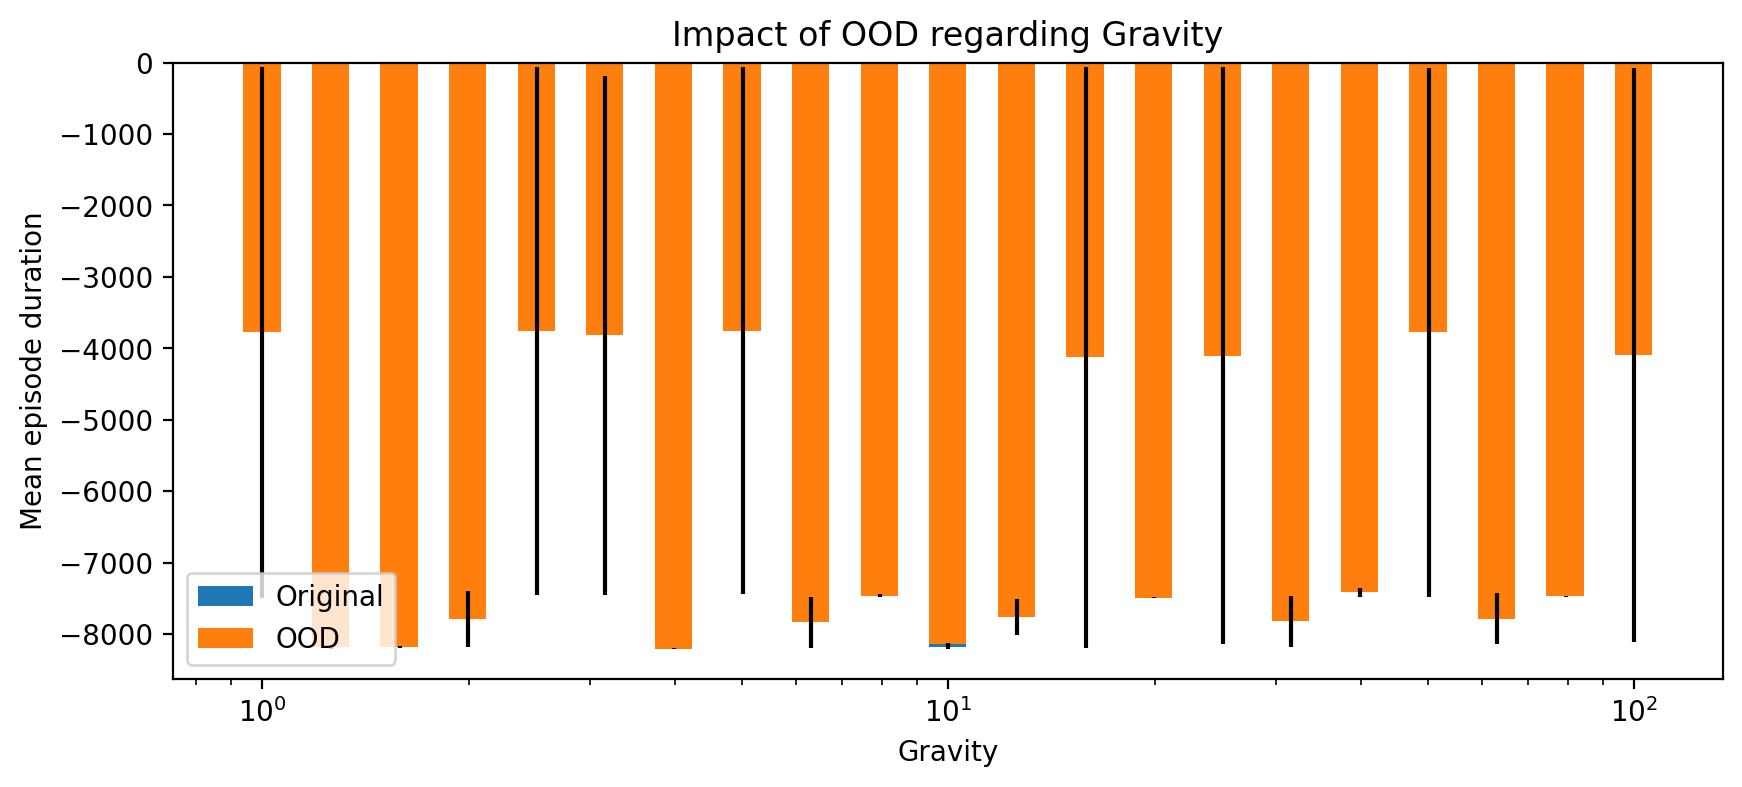

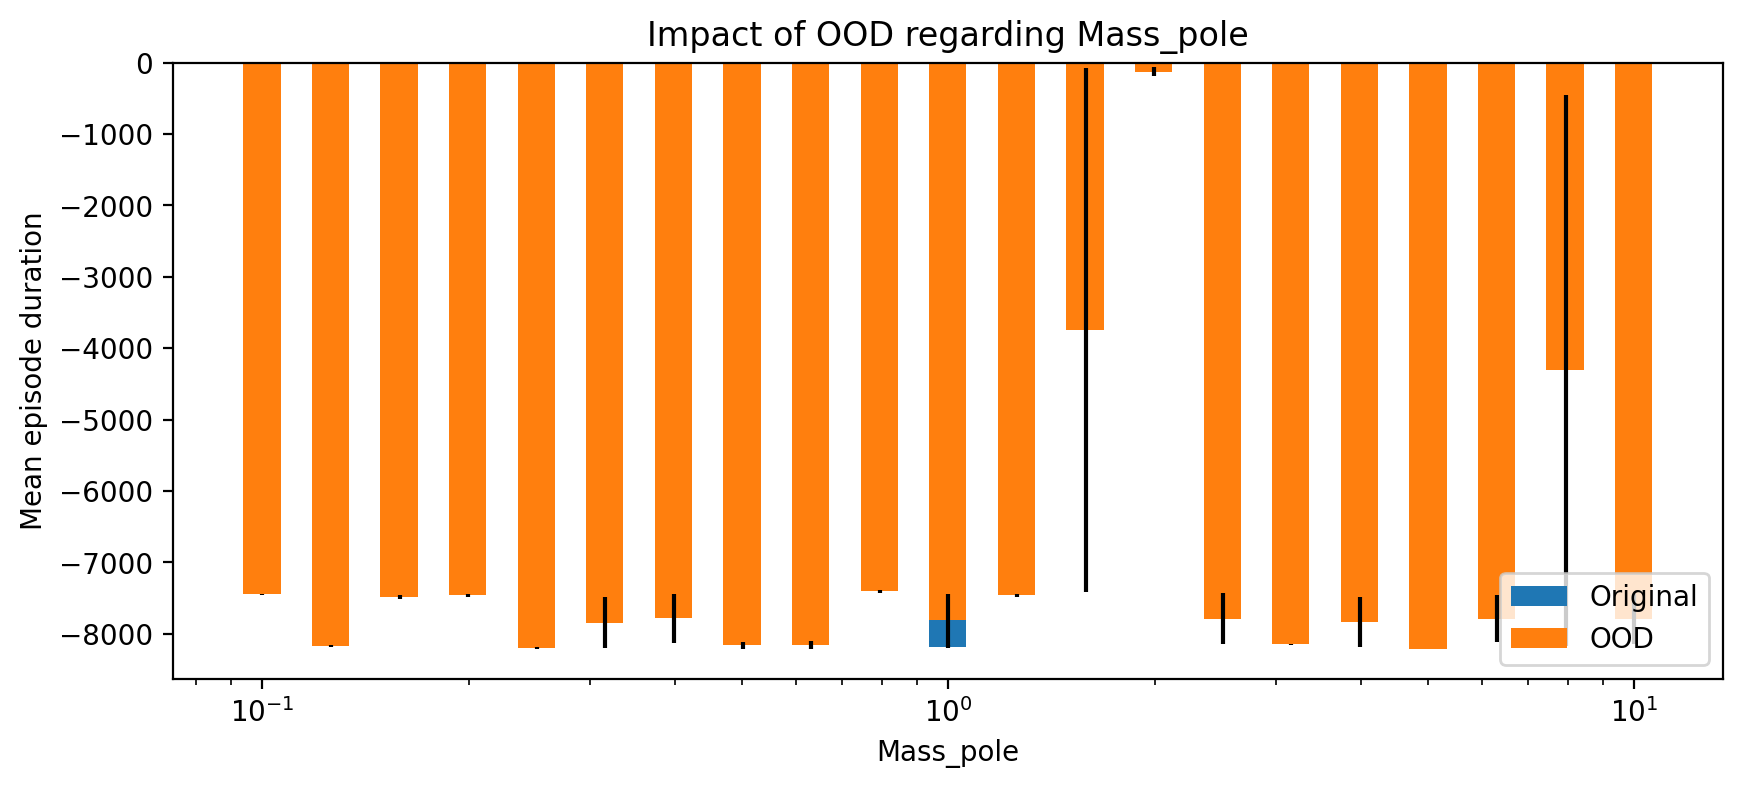

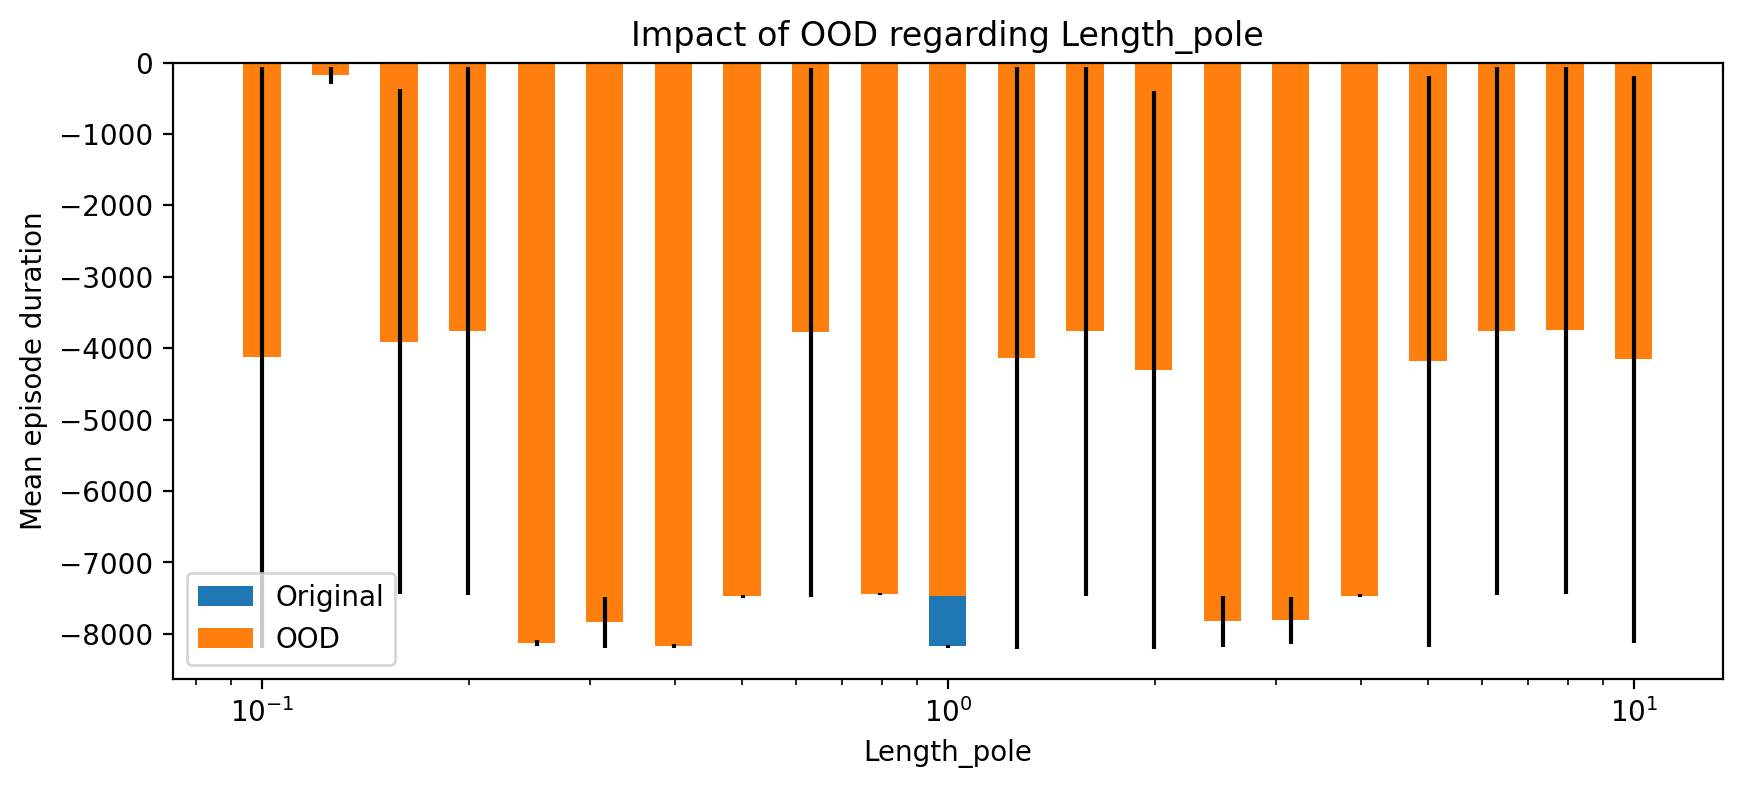

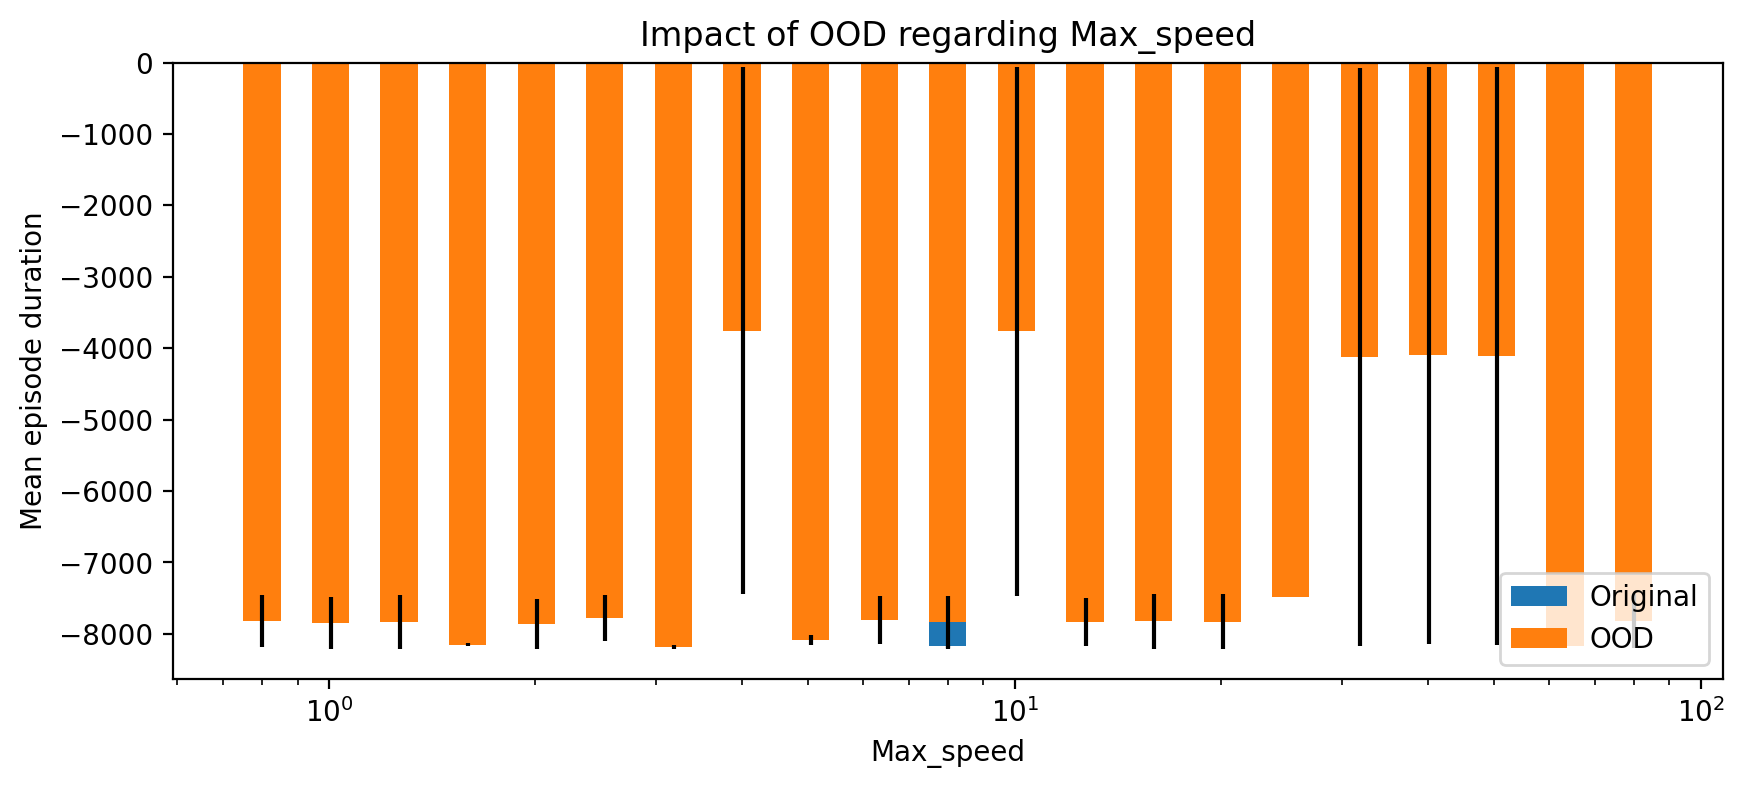

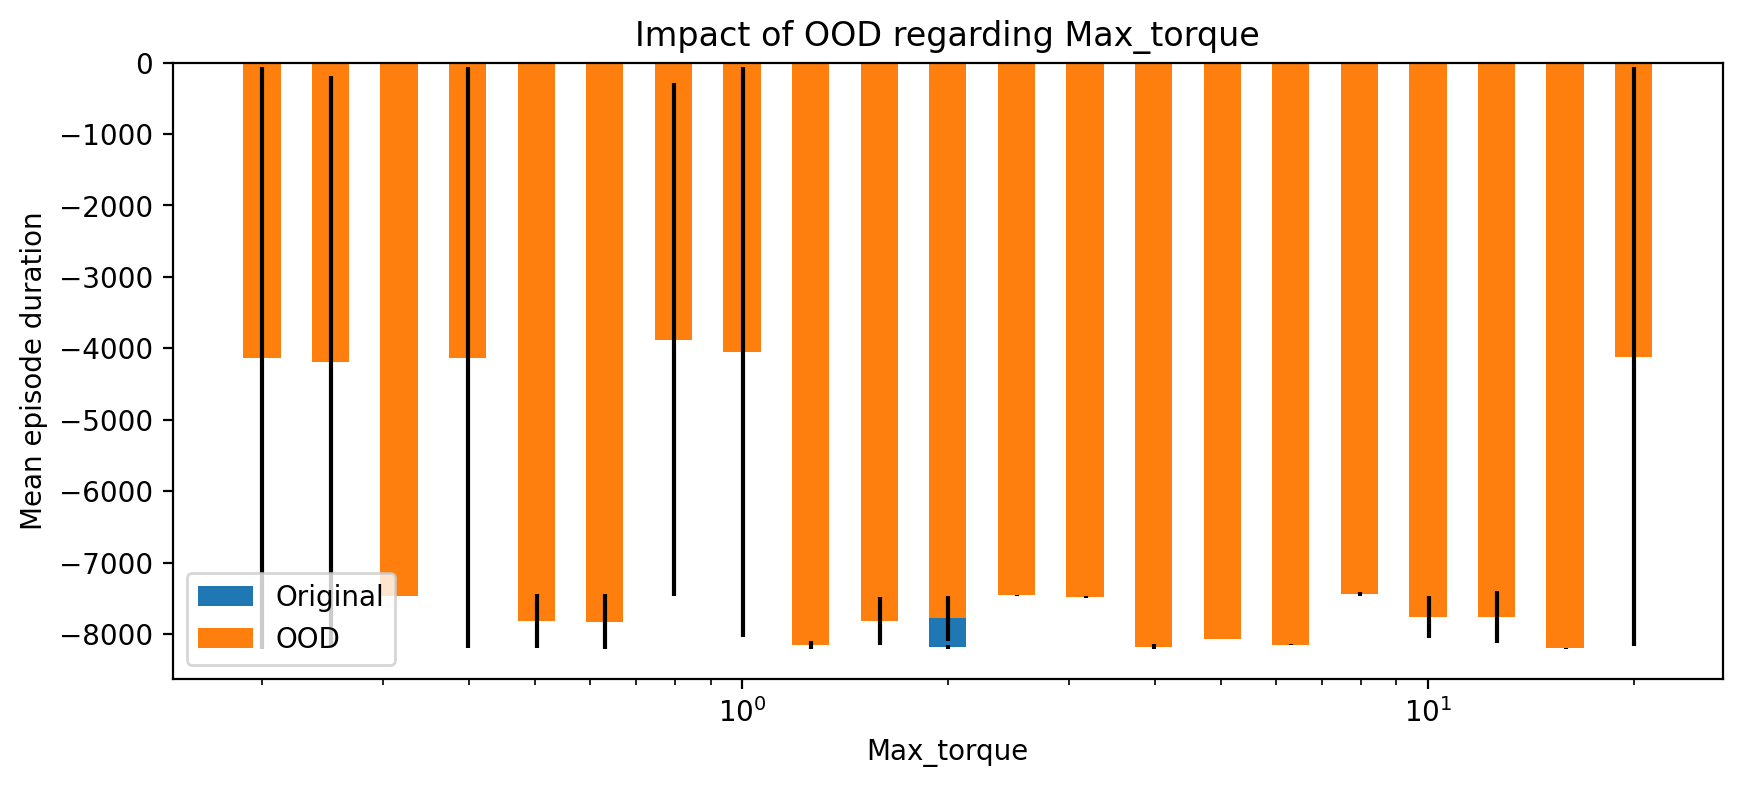

In [ ]:
for key in results:
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    
    default_width = default_values[key]/8.0
    width = default_width * np.logspace(-1, 1, num=21)
    #np.array([2**i for i in range(-5, 0)] + [2**i for i in range(1, 5+1)])

    ax.bar(default_values[key], original_result, yerr=original_std_result, width=default_width, label='Original')
    ax.bar(values[key], results[key], yerr=std_results[key], width=width, label='OOD')
    
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)
    ax.legend()
    

# Create OOD detector

The configuration ood detector is relative to its default environment

In [ ]:
env = instanciation_function(default_values)
ood_detector = MartingaleOODDetector(env, verbose=False)
print("Config", default_values)
print("In distrib OOD score:", ood_detector.get_in_distrib_score())

Config {'Gravity': 10.0, 'Mass_pole': 1.0, 'Length_pole': 1.0, 'Max_speed': 8.0, 'Max_torque': 2.0}
In distrib OOD score: 0.3445966163615043


We have a low ood score on the delaut environment

It should be higher on ood environment

In [ ]:
ood_config = get_ood_configs(default_values, values)[9]
ood_env = instanciation_function(ood_config)
print("Config", default_values)
print("OOD score:", ood_detector.test_ood(ood_env, nb_steps=100))

Config {'Gravity': 10.0, 'Mass_pole': 1.0, 'Length_pole': 1.0, 'Max_speed': 8.0, 'Max_torque': 2.0}
OOD score: 0.3445365871748359


Let's compute the ood scores of the previously studies ood environments

In [ ]:
mean_ood_scores = {}
std_ood_scores = {}

original_env = instanciation_function(default_values)
agent = A2C.load(path_agent, env=original_env)
ood_detector = MartingaleOODDetector(env)
in_distrib_score = ood_detector.get_in_distrib_score()

for config in tqdm(ood_configs):
    if config['change'] not in mean_ood_scores:
        mean_ood_scores[config['change']] = []
        std_ood_scores[config['change']] = []
    
    ood_env = instanciation_function(config)
    agent = A2C.load(path_agent)
    list_scores = np.array([ood_detector.test_ood(ood_env, nb_steps=100) for _ in range(10)])
    ood_score = list_scores.mean()
    std_score = list_scores.std()

    mean_ood_scores[config['change']].append(ood_score)
    std_ood_scores[config['change']].append(std_score)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


  0%|          | 0/105 [00:00<?, ?it/s]

We now realise a plot of the mean reward and ood scores of each environment. The ones of the delaut environment are in darker colour at the middle of the plot.

  0%|          | 0/5 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (21,) (20,) 

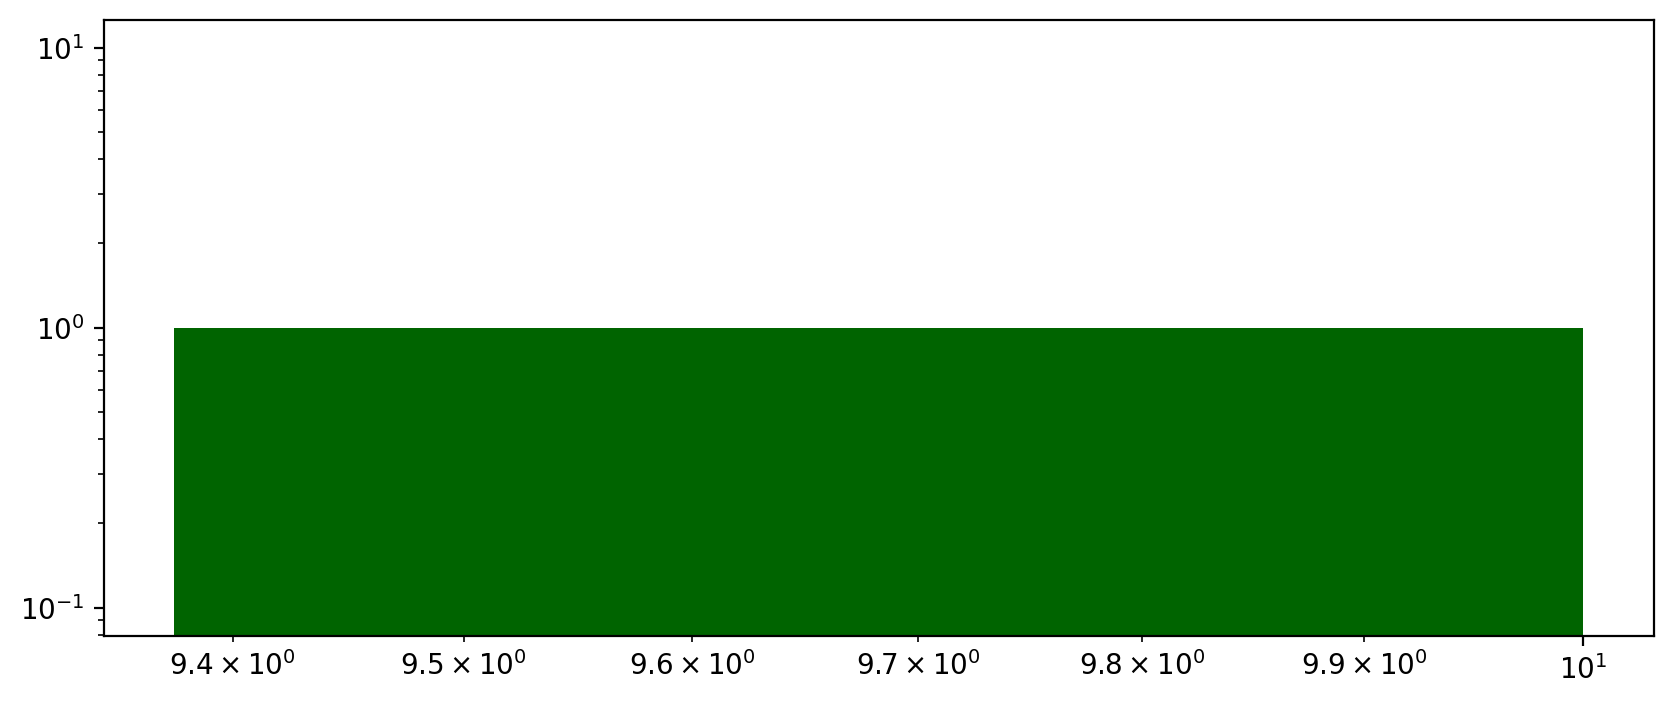

In [ ]:
from turtle import color
from numpy import inf


for key in tqdm(results):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    #default_width = default_values[key]/8.0
    #mean_ood_scores[key] = np.nan_to_num(mean_ood_scores[key], copy=True, nan=0.0, posinf=max(mean_ood_scores[key]), neginf=0)
    #std_ood_scores[key] = np.nan_to_num(std_ood_scores[key], copy=True, nan=0.0, posinf=max(std_ood_scores[key]), neginf=0)

    default_width = default_values[key]/8.0
    width = default_width * np.delete(np.logspace(-1, 1, num=21), 10)

    ax.bar(default_values[key]- default_width/4, 1.0, width=default_width/2, label='Relative return', color='darkgreen')
    ax.bar(values[key]- width/4, results[key]/original_result, width=width/2,  color='green')

    ax.bar(default_values[key]+default_width/4, 1.0, width=default_width/2, label='Relative OOD score', color='darkorange')
    ax.bar(values[key]+ width/4, mean_ood_scores[key]/in_distrib_score, width=width/2, color='orange', yerr=std_ood_scores[key])
    
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)

    plt.legend() #prop={'size': 'medium'}, ncol=2)
   

We add as maning in distribution examples and there are ood examples

In [ ]:
original_env = instanciation_function(default_values)
agent = A2C.load(path_agent, env=original_env)

list_scores = []
for _ in trange(5*18):
    list_scores.append(np.array([ood_detector.test_ood(original_env, nb_steps=100) for _ in range(10)]).mean())

mean_ood_scores['None'] = list_scores

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


100%|██████████| 90/90 [00:37<00:00,  2.42it/s]


# Detection speed at a fixed threshold

In [ ]:
original_env = instanciation_function(default_values)
list_scores = np.array([ood_detector.test_ood(original_env, nb_steps=1000) for _ in range(100)])
ood_score = list_scores.mean()
std_score = list_scores.std()
threshold = ood_score + 10*std_score

ood_score, std_score, threshold

(0.2536888216259829, 0.0002826907305392452, 0.25651572893137536)

In [ ]:
np.array([ood_detector.test_ood(original_env, nb_steps=100) for _ in range(100)]) > threshold

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [ ]:
ood_detector = MartingaleOODDetector(original_env)

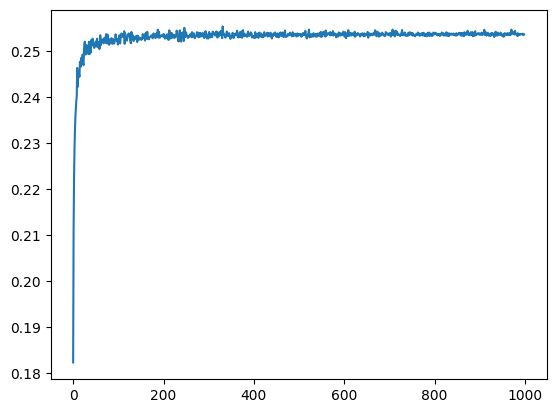

In [ ]:
Y = [ood_detector.test_ood(original_env, nb_steps=n) for n in range(1,1000)]
plt.plot(Y)

In [ ]:
stop_in_distrib, ood_in_distrib = ood_detector.stop_above_threshold(original_env, threshold, start_at=50, nb_steps=1000)

In [ ]:

mean_ood_stops = {}
std_ood_stops = {}

original_env = instanciation_function(default_values)
agent = A2C.load(path_agent, env=original_env)
ood_detector = MartingaleOODDetector(env)


for config in tqdm(ood_configs):
    if config['change'] not in mean_ood_stops:
        mean_ood_stops[config['change']] = []
        std_ood_stops[config['change']] = []
    
    ood_env = instanciation_function(config)
    agent = A2C.load(path_agent)
    list_stops = np.array([ood_detector.stop_above_threshold(original_env, threshold, start_at=30, nb_steps=1000)[0] for _ in range(10)])
    mean_ood_stop = list_stops.mean()
    std_ood_stop = list_stops.std()

    #mean_reward, std_reward = evaluate(ood_env, agent, nb_episodes=10)

    mean_ood_stops[config['change']].append(mean_ood_stop)
    std_ood_stops[config['change']].append(std_ood_stop)
    #print(config, mean_reward)
    



Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


  0%|          | 0/100 [00:00<?, ?it/s]

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

In [ ]:
original_result = 1000.0
stop_in_distrib = 100.0

  0%|          | 0/5 [00:00<?, ?it/s]

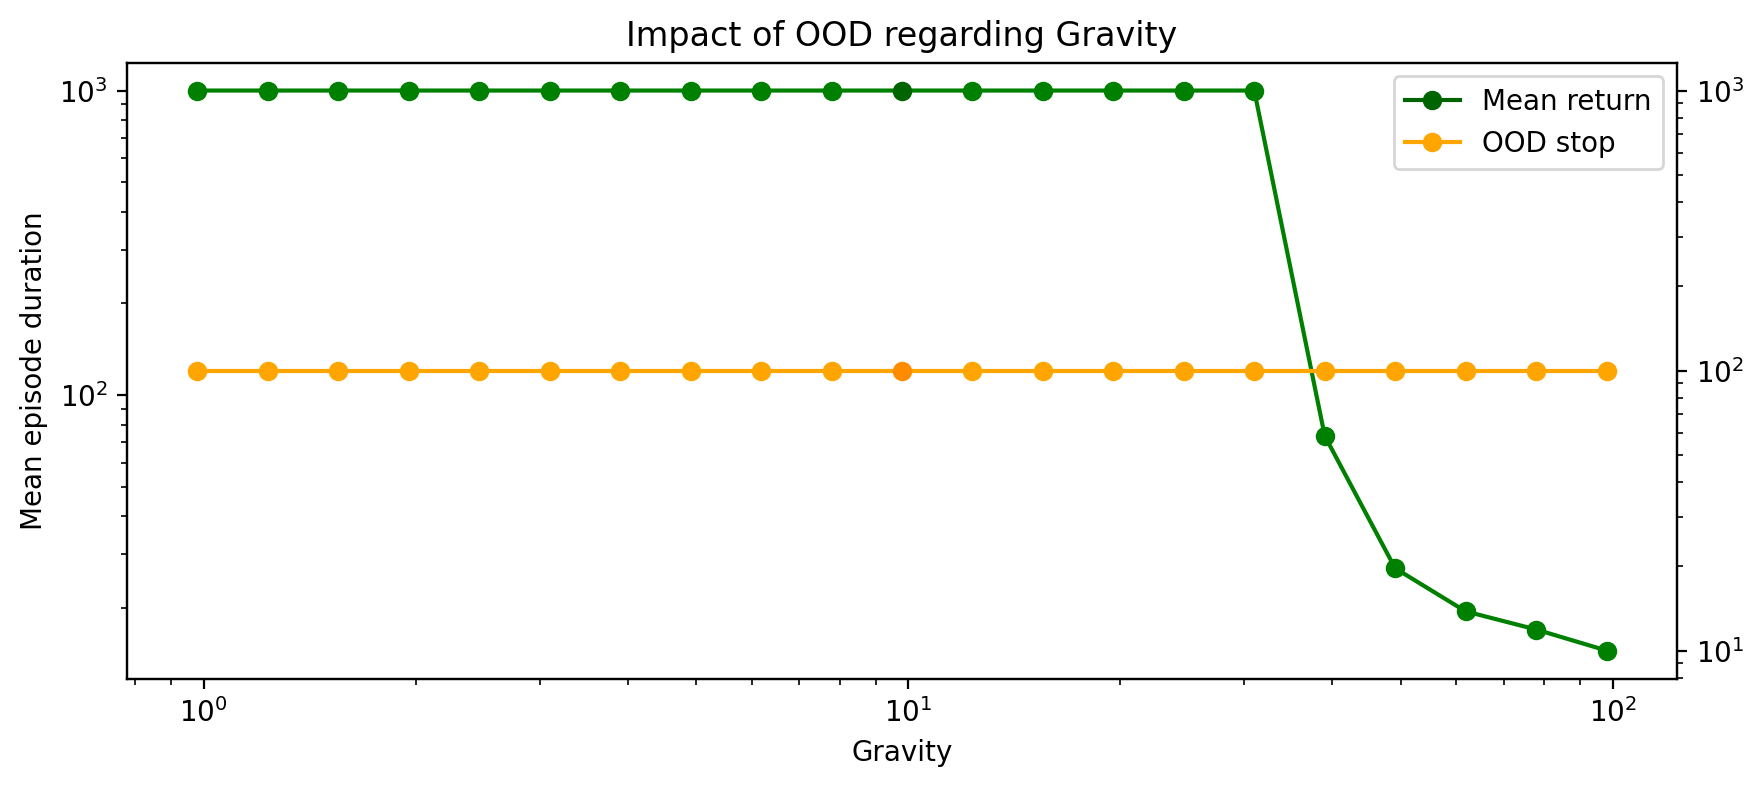

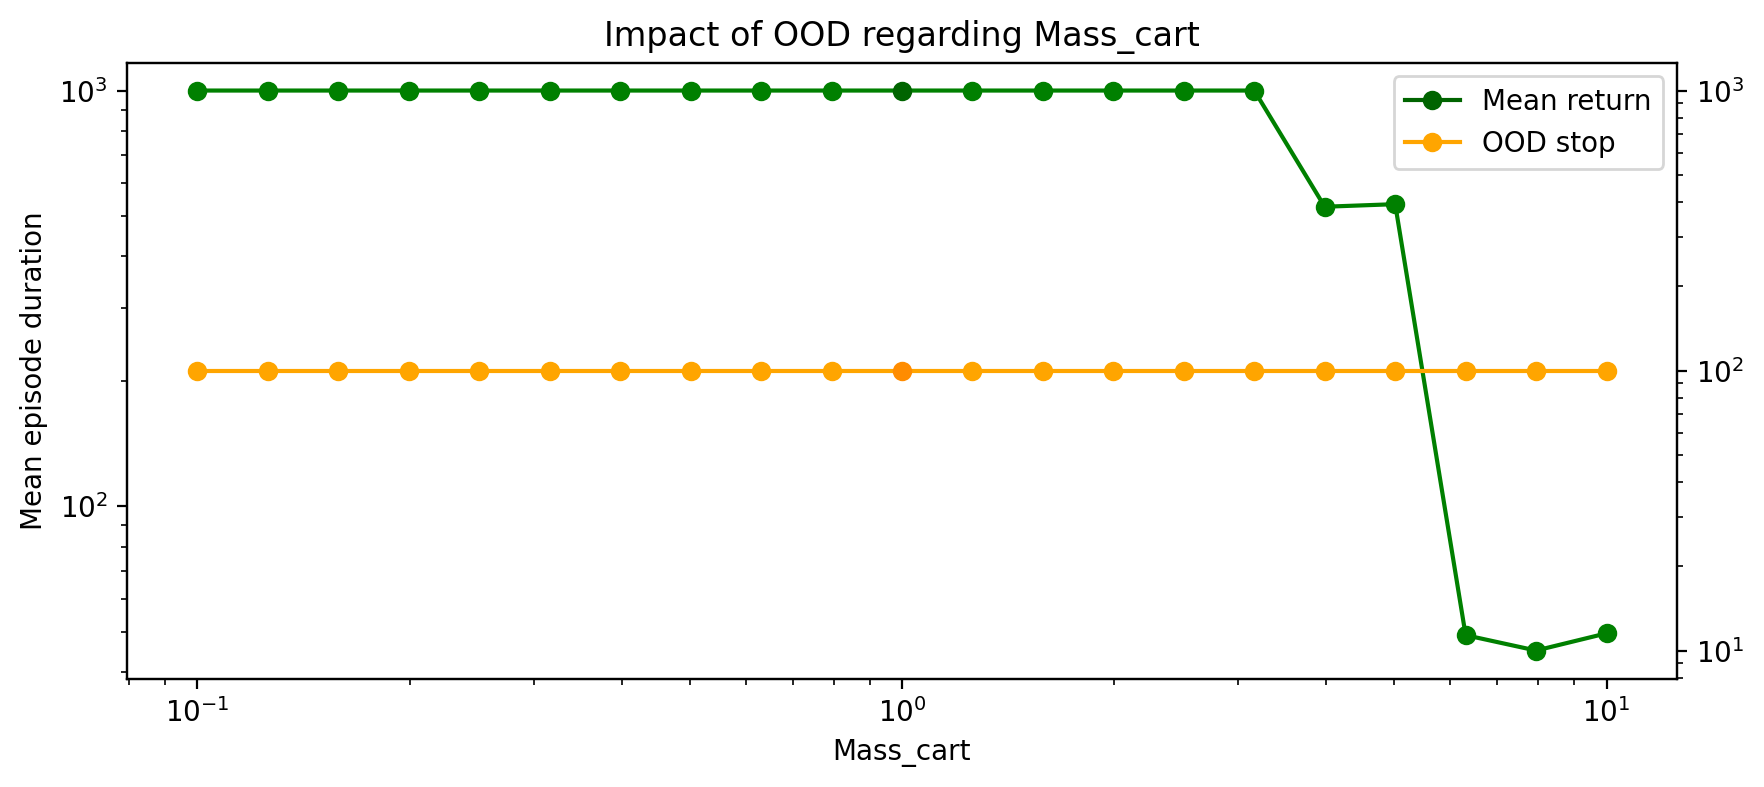

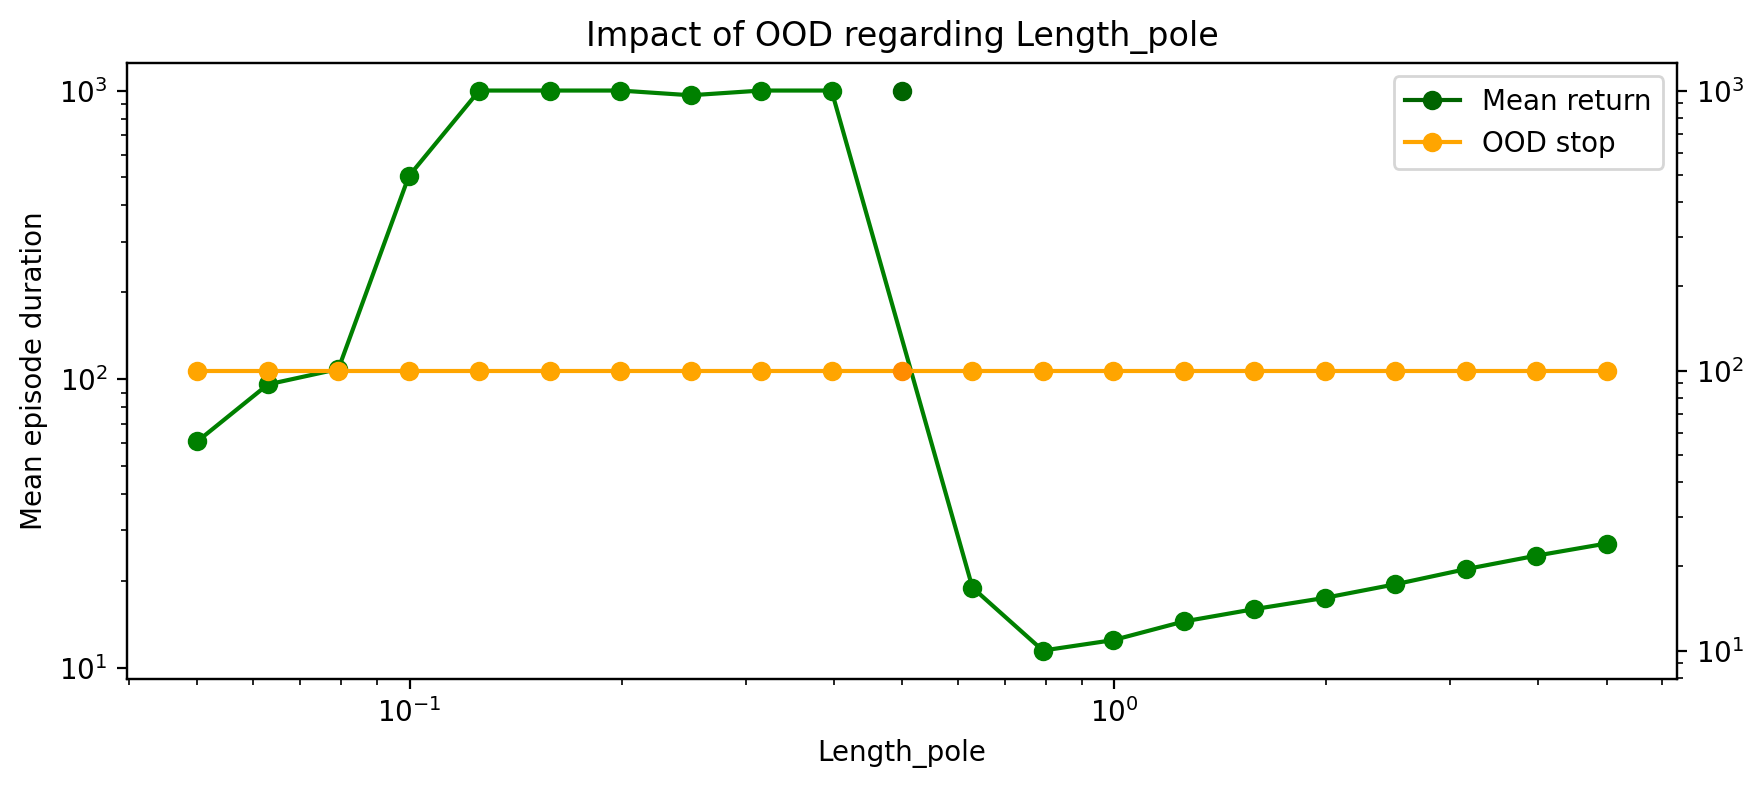

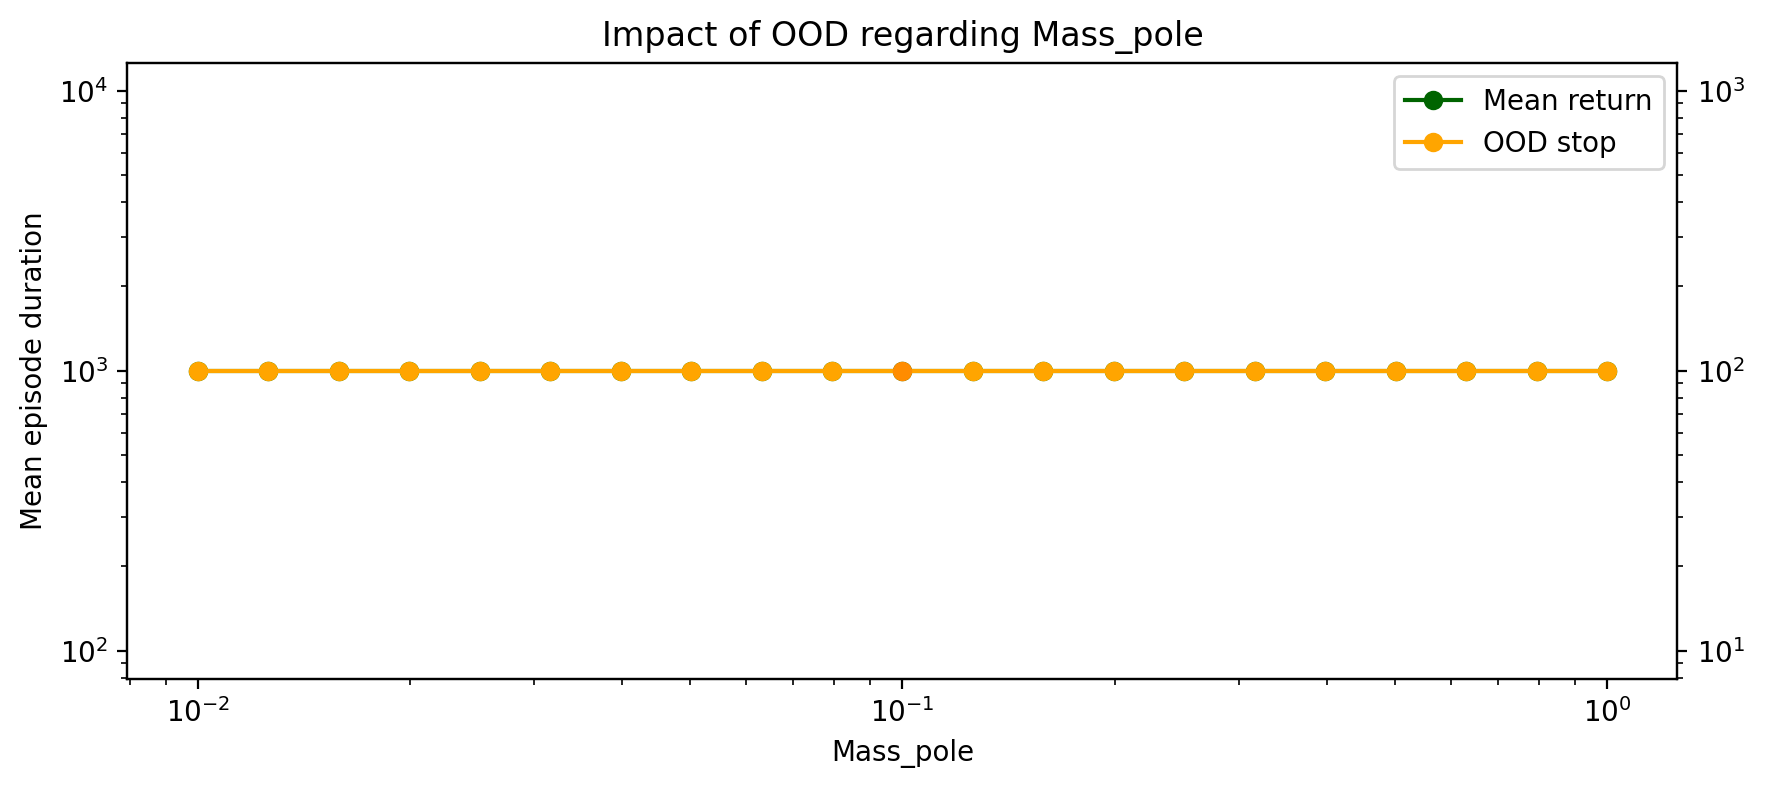

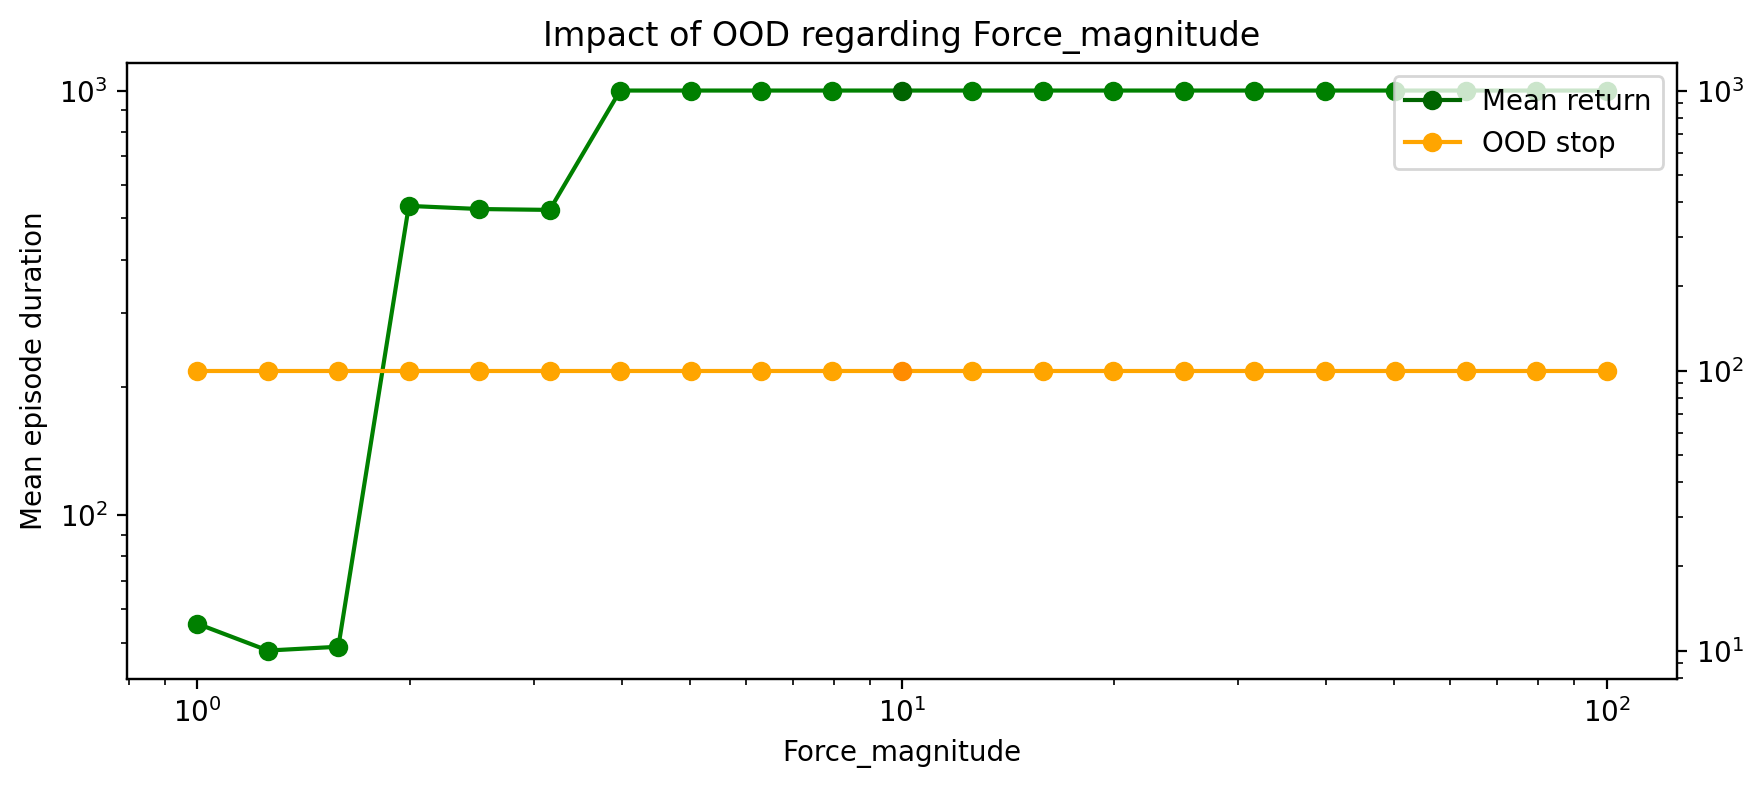

In [ ]:
from turtle import color
from numpy import inf


for key in tqdm(results):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax2=ax.twinx()
    ax2.set_yscale('log')
    
    #mean_ood_scores[key] = np.nan_to_num(mean_ood_scores[key], copy=True, nan=0.0, posinf=max(mean_ood_scores[key]), neginf=0)
    #std_ood_scores[key] = np.nan_to_num(std_ood_scores[key], copy=True, nan=0.0, posinf=max(std_ood_scores[key]), neginf=0)

    default_width = default_values[key]/12.0
    width = default_width * np.delete(np.logspace(-1, 1, num=21), 10)
    #print(width, np.array([width[-1]]))
    #width = np.concatenate((width, np.array([width[-1]])))/ 5
    #print(width)

    #ax.bar(default_values[key]- default_width/2, original_result, width=default_width, label='Mean return', color='darkgreen')
    #ax.bar(values[key]- width/2, results[key], width=width,  color='green')

    #ax.bar(default_values[key]+default_width/2, stop_in_distrib, width=default_width, label='OOD stop', color='darkorange')
    #ax.bar(values[key]+ width/2, mean_ood_stops[key], width=width, color='orange', yerr=std_ood_scores[key])
    
    ax.plot(values[key], results[key], label='Mean return', marker='o',color='green')
    ax.plot(default_values[key], original_result, marker='o',color='darkgreen')
    
    ax2.plot([], [], marker='o',color='darkgreen', label='Mean return')
    ax2.plot(values[key], mean_ood_stops[key], label='OOD stop', marker='o',color='orange')
    ax2.plot(default_values[key], stop_in_distrib,  marker='o',color='darkorange')
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)

    plt.legend() #prop={'size': 'medium'}, ncol=2)
   

# Computation of the AUC score

In [ ]:
def compute_AUC(mean_ood_scores, plot=True, verbose=False):
    TPRs = []
    FPRs = []

    thresholds = [10**(-i/10) for i in range(-50, 50+1)]
    for threshold in thresholds:
        false_pos=0
        false_neg=0
        true_pos=0
        true_neg=0

        for key in mean_ood_scores:
            if str(key) != 'None': # Env OOD
                for test_res in mean_ood_scores[key]:

                    if test_res<threshold: # Not detected as OOD
                        false_neg +=1
                    else:
                        true_pos +=1
            else: # Env standard
                for test_res in mean_ood_scores[key]:

                    if test_res>threshold: # Detected as OOD
                        false_pos +=1
                    else:
                        true_neg +=1


        try:
            tpr = true_pos/(true_pos+false_neg)
        except ZeroDivisionError:
            print('error computing tpr')
            continue
            tpr = 1.0
        
        try:
            fpr = false_pos/(false_pos+true_neg)
        except ZeroDivisionError:
            print('error computing fpr')
            continue

        if verbose:
            print(threshold)
            print('TP', true_pos, 'FP',false_pos)
            print('FN', false_neg, 'TN',true_neg)
            print()
            print(tpr, fpr)
        TPRs.append(tpr)
        FPRs.append(fpr)
        #AUC += tpr/len(thresholds)

    if verbose:
        plt.title("TPR and FPR curves")
        plt.plot(TPRs, label='TPR')
        plt.plot(FPRs, label='FPR')
        plt.legend()
        plt.show()
        
    #print('AUC: ', AUC)
    plt.title("ROC curve")
    plt.plot(FPRs, TPRs,'-*')
    plt.xlabel('TPR')
    plt.ylabel('FPR')
    plt.show()

    AUC = integrate.simps(x=FPRs, y=TPRs, even='avg')
    return AUC

In [ ]:
compute_AUC(mean_ood_scores)